In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Sfilter
import sympy as sp
from scipy.optimize import fsolve
from scipy import stats
from Sfilter import Langevin


In [2]:
def top6(x):
    E = 1.5*np.cos(x*2)   + 0.5*np.cos(4*(x+0.01)) - 0.3*np.cos(6*x) - 0.6*np.sin(x) - 0.15 * x
    F =   3.0*np.sin(2*x) + 2.0*np.sin(4*x + 0.04) - 1.8*np.sin(6*x) + 0.6*np.cos(x) + 0.15
    return E, F

x = sp.symbols('x')
E = 1.5*sp.cos(x*2) + 0.5*sp.cos(4*(x+0.01)) - 0.3*sp.cos(6*x) - 0.6*sp.sin(x) - 0.15 * x
force = -sp.diff(E, x)
print(force)

3.0*sin(2*x) - 1.8*sin(6*x) + 2.0*sin(4*x + 0.04) + 0.6*cos(x) + 0.15


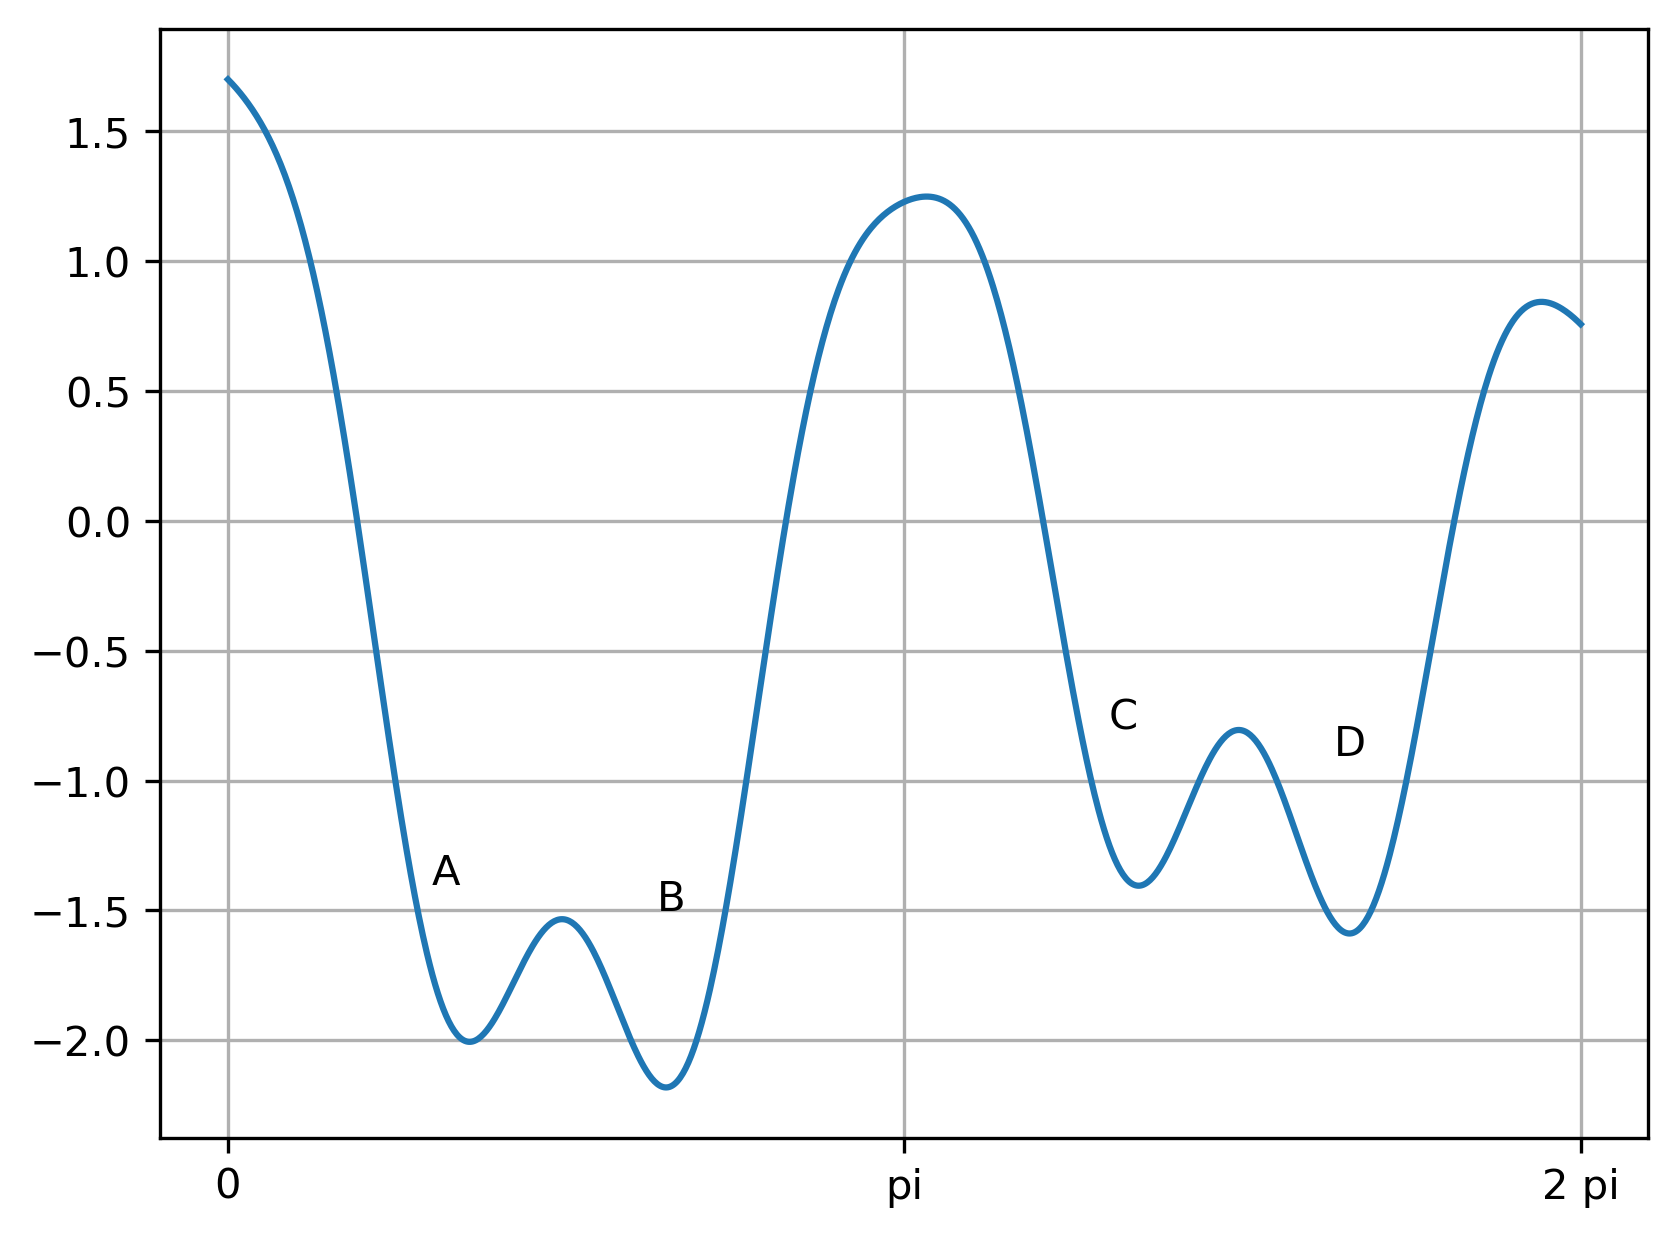

In [3]:
plt.figure(1, dpi=300)
x_axis = np.linspace(0, np.pi * 2, 1000)
plt.plot(x_axis, top6(x_axis)[0])
plt.xticks([0,np.pi, 2*np.pi,], ["0", "pi", "2 pi",])
plt.grid()
plt.text(1/3*np.pi-0.1, -1.4, "A")
plt.text(2/3*np.pi-0.1, -1.5, "B")
plt.text(4/3*np.pi-0.1, -0.8, "C")
plt.text(5/3*np.pi-0.1, -0.9, "D")
plt.savefig("top.png")

In [4]:
def only_force(func):
    def wrapper(*args, **kwargs):
        _, force = func(*args, **kwargs)
        return force
    return wrapper
top6_force = only_force(top6)

In [5]:
guess_max = np.pi * np.array([0, 0.5, 1, 1.5, 2])
guess_min = np.pi * np.array([0.25, 0.75, 1.25, 1.75, 2.25])

x_0_min = fsolve(top6_force, guess_min)
x_0_max = fsolve(top6_force, guess_max)

print("min")
print(x_0_min)
print(top6(x_0_min)[0])
print("max")
print(x_0_max)
print(top6(x_0_max)[0])
print("Barrier")
b_0 = top6(x_0_max)[0][1:] - top6(x_0_min)[0][:-1]
print(b_0)
b_1 = top6(x_0_max)[0] - top6(x_0_min)[0]
print(b_1)

min
[1.12256259 2.03511884 4.22985094 5.2095107  7.4057479 ]
[-2.00608687 -2.18170963 -1.40493627 -1.58891839 -2.94856467]
max
[-0.18194921  1.55190914  3.24518818  4.69520115  6.1012361 ]
[ 1.78566393 -1.53384946  1.24856406 -0.80528313  0.84318613]
Barrier
[0.47223741 3.43027369 0.59965314 2.43210453]
[3.7917508  0.64786017 2.65350033 0.78363527 3.7917508 ]


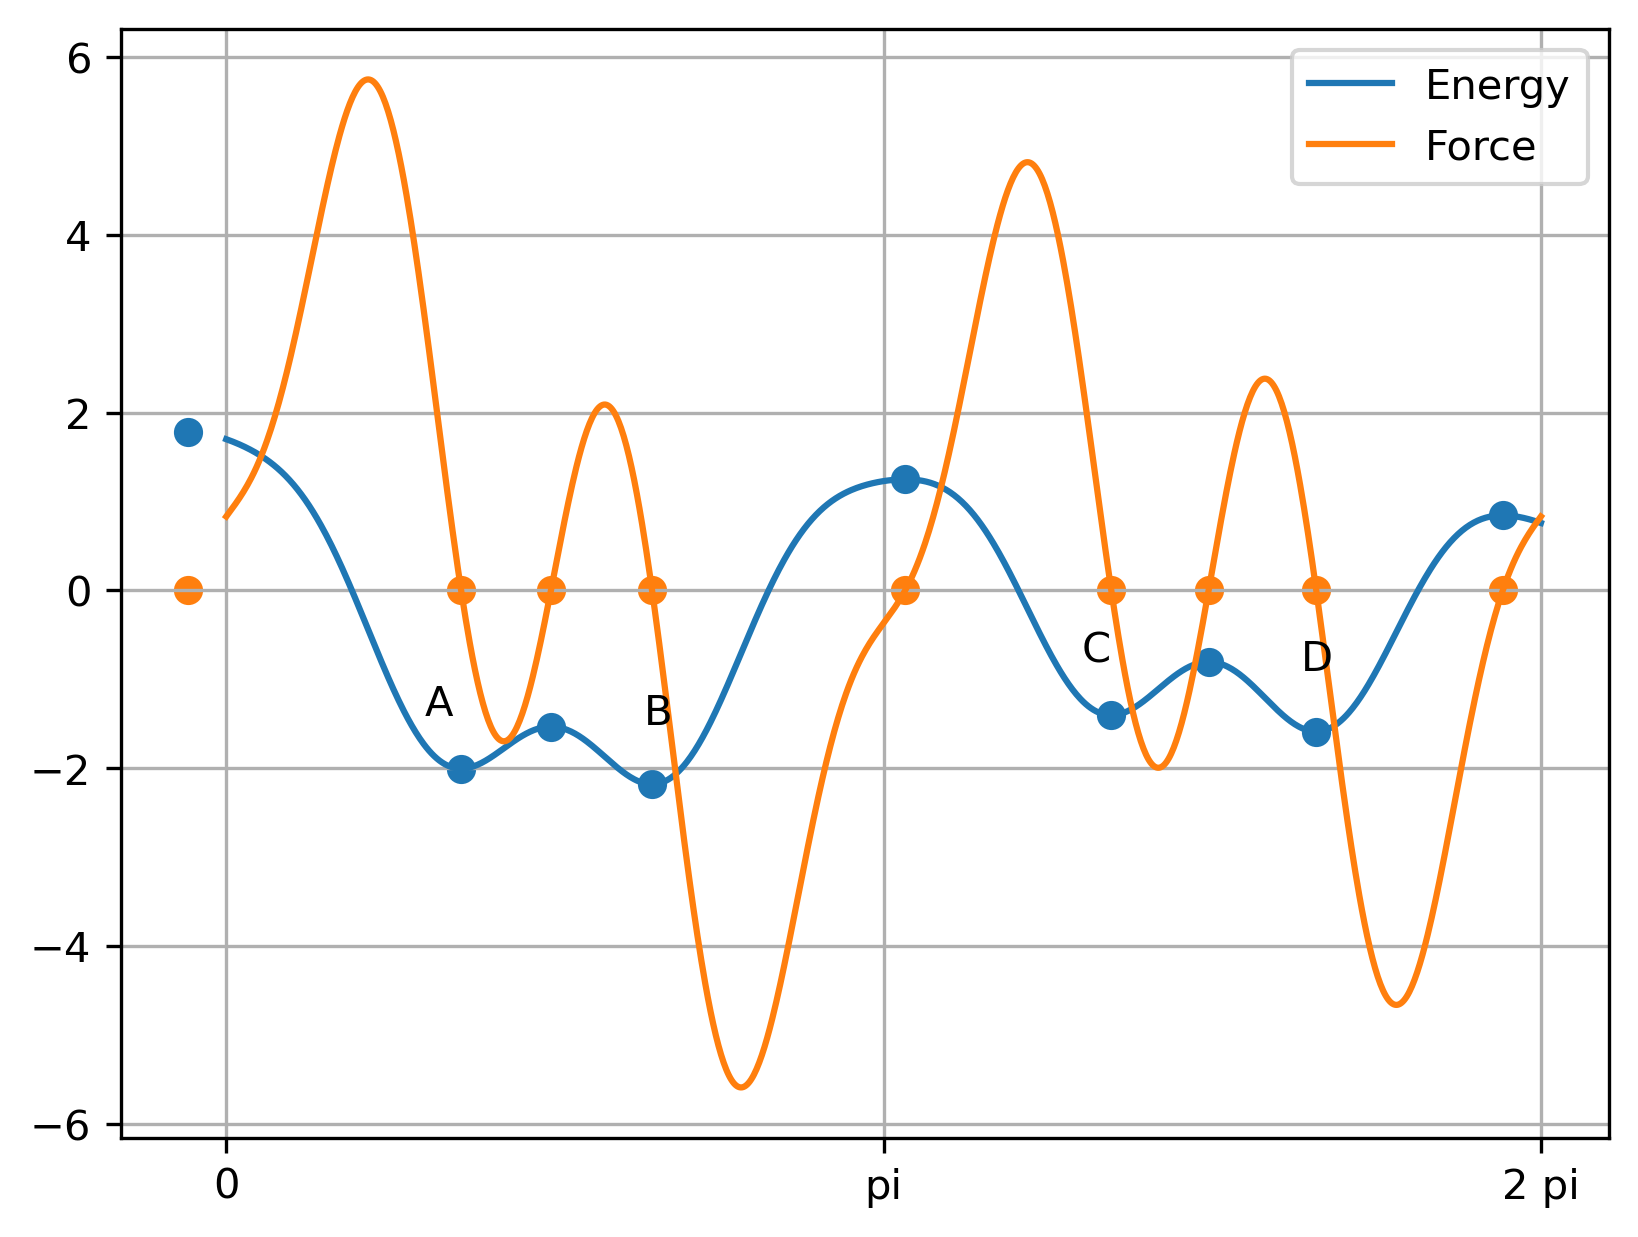

In [23]:
plt.figure(2, dpi=300)
x_axis = np.linspace(0, np.pi * 2, 1000)
E, F = top6(x_axis)
plt.plot(x_axis, E, label="Energy")
plt.plot(x_axis, F, label="Force")
plt.xticks([0,np.pi, 2*np.pi,], ["0", "pi", "2 pi",])
plt.grid()
plt.legend()
x_zeros = np.concatenate((x_0_min[:-1], x_0_max))
plt.scatter(x_zeros, top6(x_zeros)[0])
plt.scatter(x_zeros, top6(x_zeros)[1])
plt.text(1/3*np.pi-0.1, -1.4, "A")
plt.text(2/3*np.pi-0.1, -1.5, "B")
plt.text(4/3*np.pi-0.1, -0.8, "C")
plt.text(5/3*np.pi-0.1, -0.9, "D")
plt.savefig("top_force.png")

In [6]:
barrier_ref = {"A_B":b_0[0],
               "B_C":b_0[1],
               "C_D":b_0[2],
               "D_A":b_0[3],
               "A_D":b_1[0],
               "B_A":b_1[1],
               "C_B":b_1[2],
               "D_C":b_1[3],
              }


In [7]:
gamma = 0.1
dt = 0.01
max_steps = 1000000
kBT = 1

save_freq = 1

In [8]:
top  = top6
initial_position = 2
initial_velocity = 10
rep=0
positions, (x,v) = Langevin.baoab(top,
                                  max_steps,
                                  dt, gamma,
                                  kBT,
                                  initial_position,
                                  initial_velocity,
                                  save_frequency=save_freq)
positions = np.array(positions)
np.save(f"md_{rep:03d}.npy", positions)
for rep in range(1,10):
    print(rep)
    x = x % (2 * np.pi) # should not be applied to top3
    positions, (x,v) = Langevin.baoab(top,
                                      max_steps,
                                      dt, gamma,
                                      kBT,
                                      x,
                                      v,
                                      save_frequency=save_freq)
    positions = np.array(positions)
    np.save(f"md_{rep:03d}.npy", positions)

1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, 'PBC nojump, no-eq MD')

<Figure size 1920x1440 with 0 Axes>

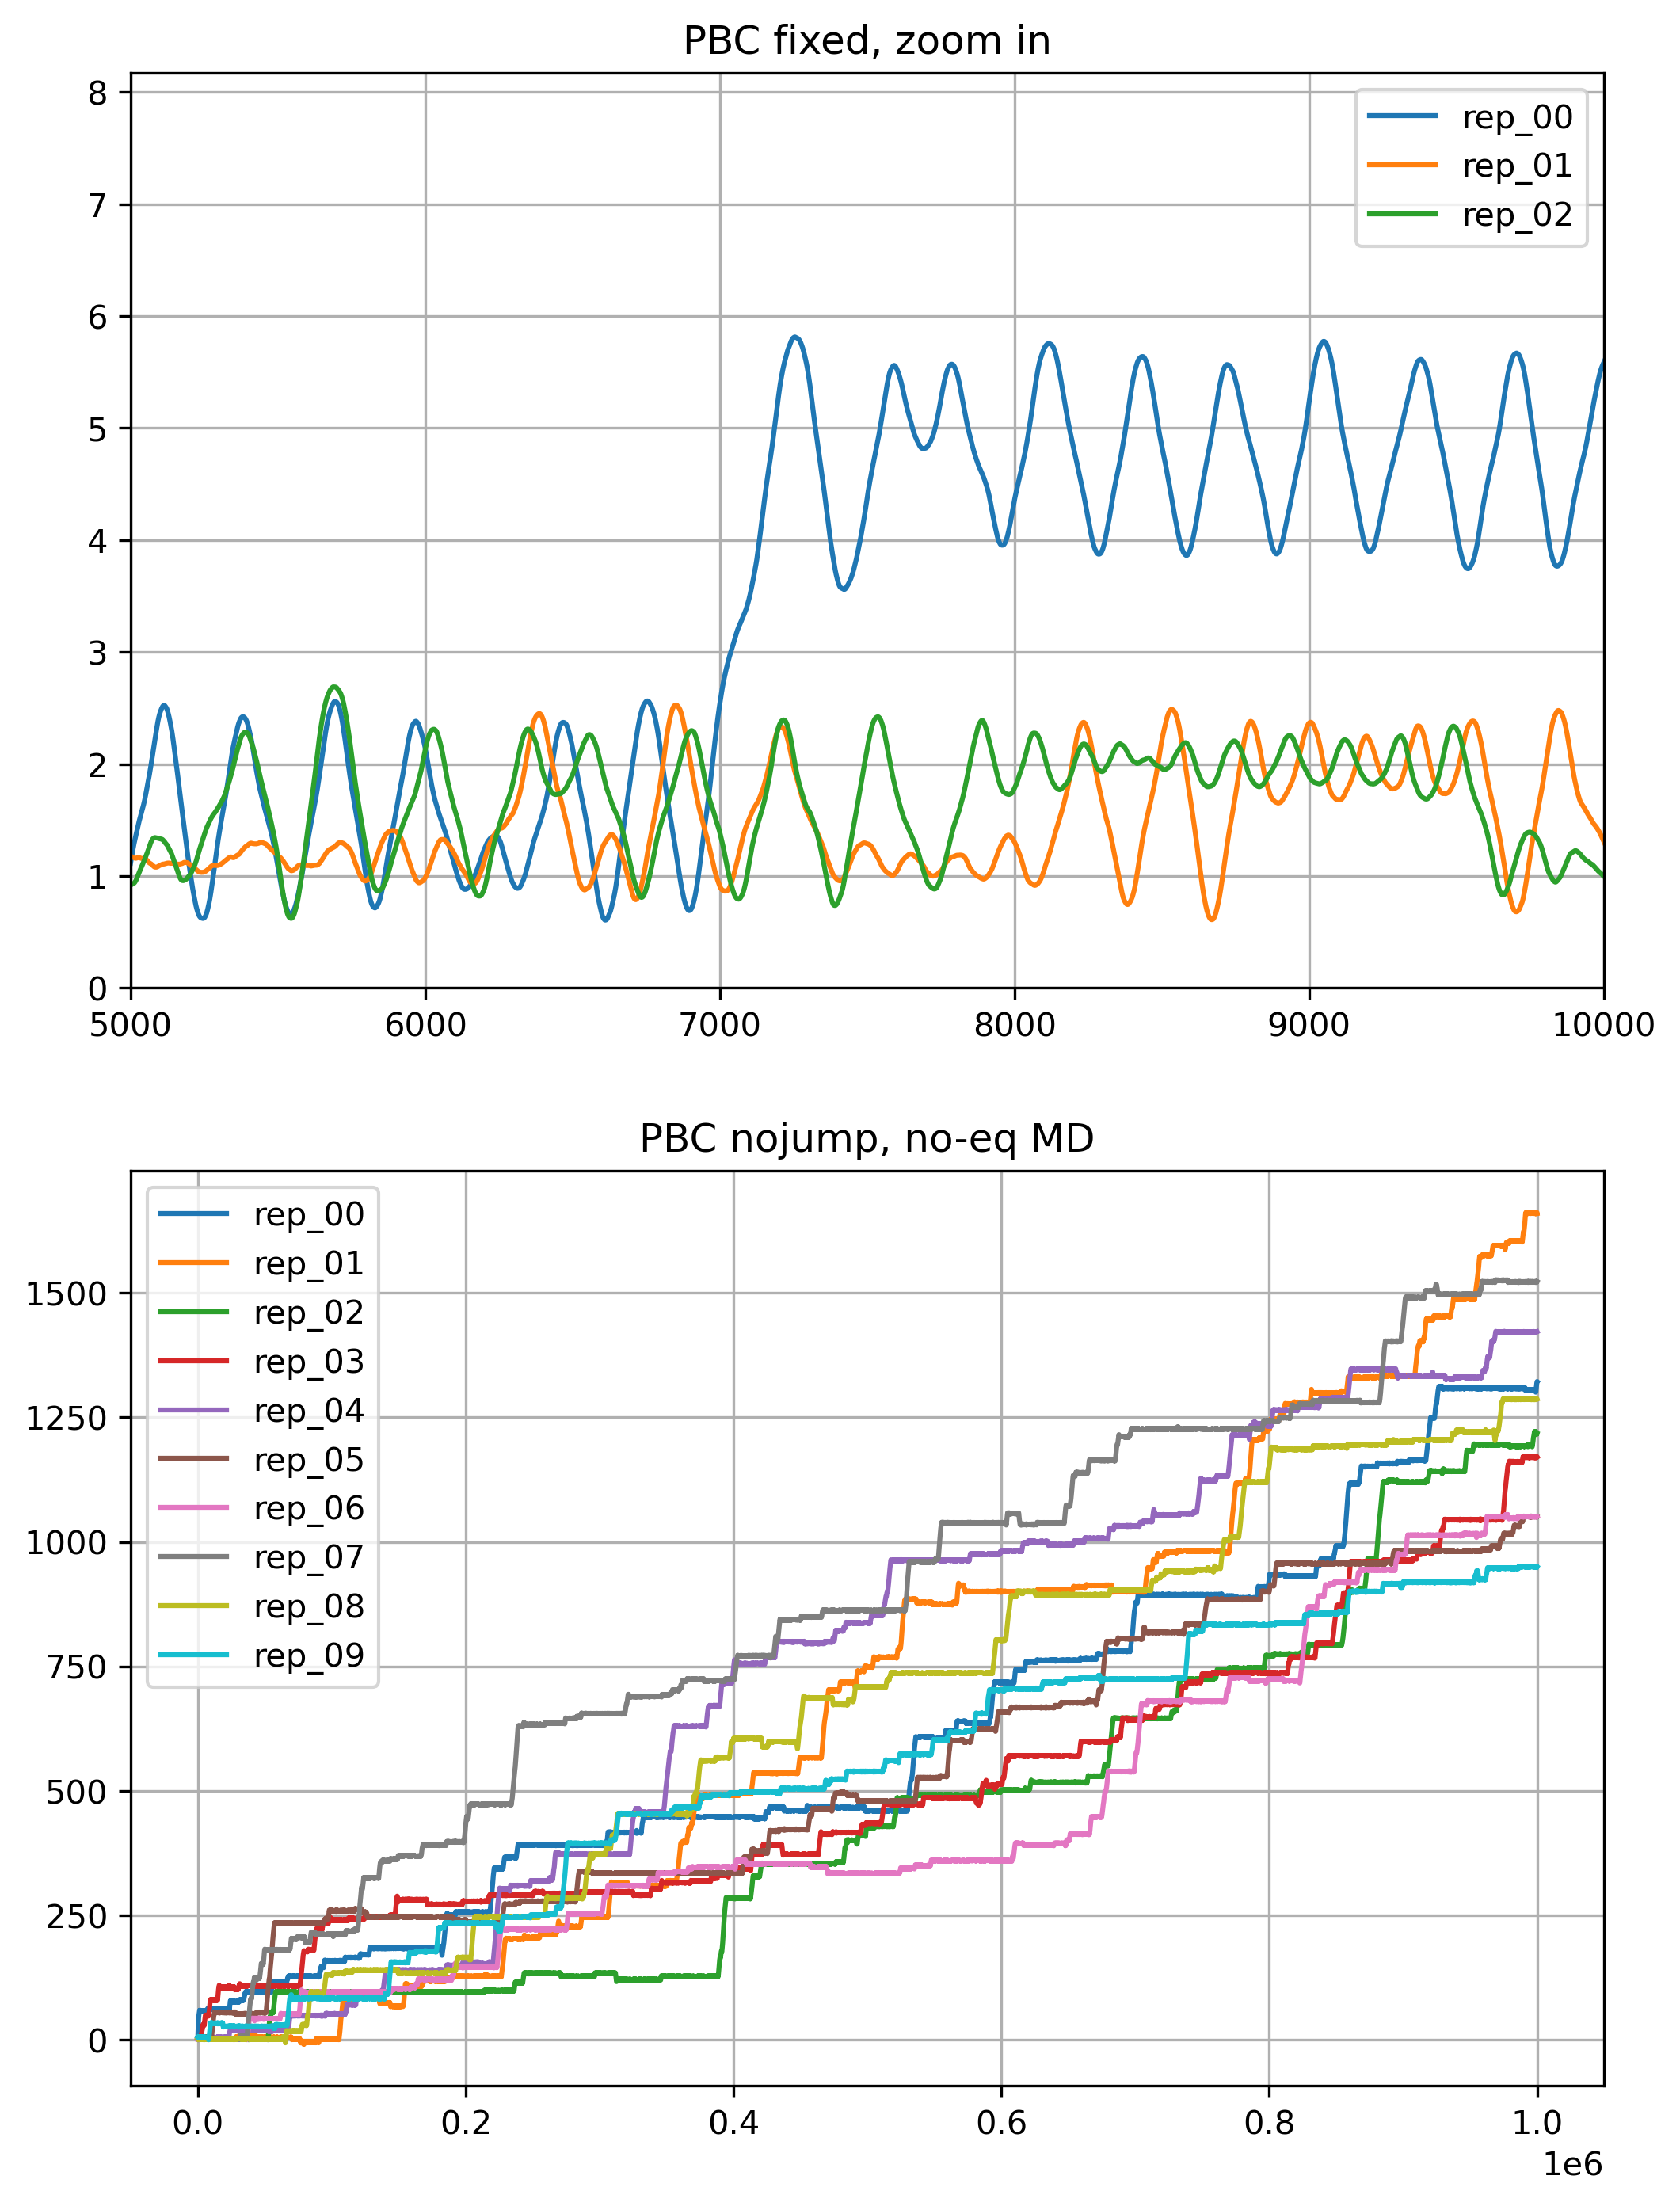

In [8]:
traj_list = []
plt.figure(1, dpi=300)
cut_off_list = x_0_max
fig, (ax1, ax2) = plt.subplots(2,1,dpi=300, figsize=(8,11))
for rep in range(10):
    name = f"md_{rep:03d}.npy"
    traj_array = np.load(name)
    if rep <= 2:
        ax1.plot(traj_array%(2*np.pi), label=f"rep_{rep:02d}", markersize=2)
    ax2.plot(traj_array, label=f"rep_{rep:02d}")
    traj_array = traj_array % (np.pi * 2)
    traj_str = np.chararray(traj_array.shape, unicode=True)
    traj_str[:] = "D"
    traj_str[traj_array > cut_off_list[0]] = "A"
    traj_str[traj_array > cut_off_list[1]] = "B"
    traj_str[traj_array > cut_off_list[2]] = "C"
    traj_str[traj_array > cut_off_list[3]] = "D"
    traj_list.append(traj_str)
    
ax1.legend()
ax2.legend()
ax1.set_xlim(5000,10001)
ax1.set_ylim(0, 2.6*np.pi)
ax1.grid()
ax2.grid()

ax1.set_title("PBC fixed, zoom in")
ax2.set_title("PBC nojump, no-eq MD")

# How do the properties change when we slice the traj?

In [9]:
rate_mfpt = {i:[] for i in barrier_ref}
rate_nft  = {i:[] for i in barrier_ref}

step_list = [1,       2,    4,    8,  16,
             32,     64,  128,  256, 512,
             1024, 2048, 4096, 8192]

for step in step_list:
    print(step)
    msm = Sfilter.MSM.SF_msm([])
    msm.set_state_str([traj[::step] for traj in traj_list])
    msm.time_step = [step]*10
    msm.calc_state_array()
    
    for b_name in barrier_ref:
        i_s,j_s = b_name.split("_")
        
        r = msm.get_mfpt_rate_pair(msm.s_2_int[i_s], msm.s_2_int[j_s])[0]
        rate_mfpt[b_name].append(r)
        
        r = msm.get_nfp_rate_pair(msm.s_2_int[i_s], msm.s_2_int[j_s])[0]
        rate_nft[b_name].append(r)
    

1
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192


In [10]:
msm.time_step

[8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192, 8192]

A_B
B_C
C_D
D_A
B_A
C_B
D_C
C_D


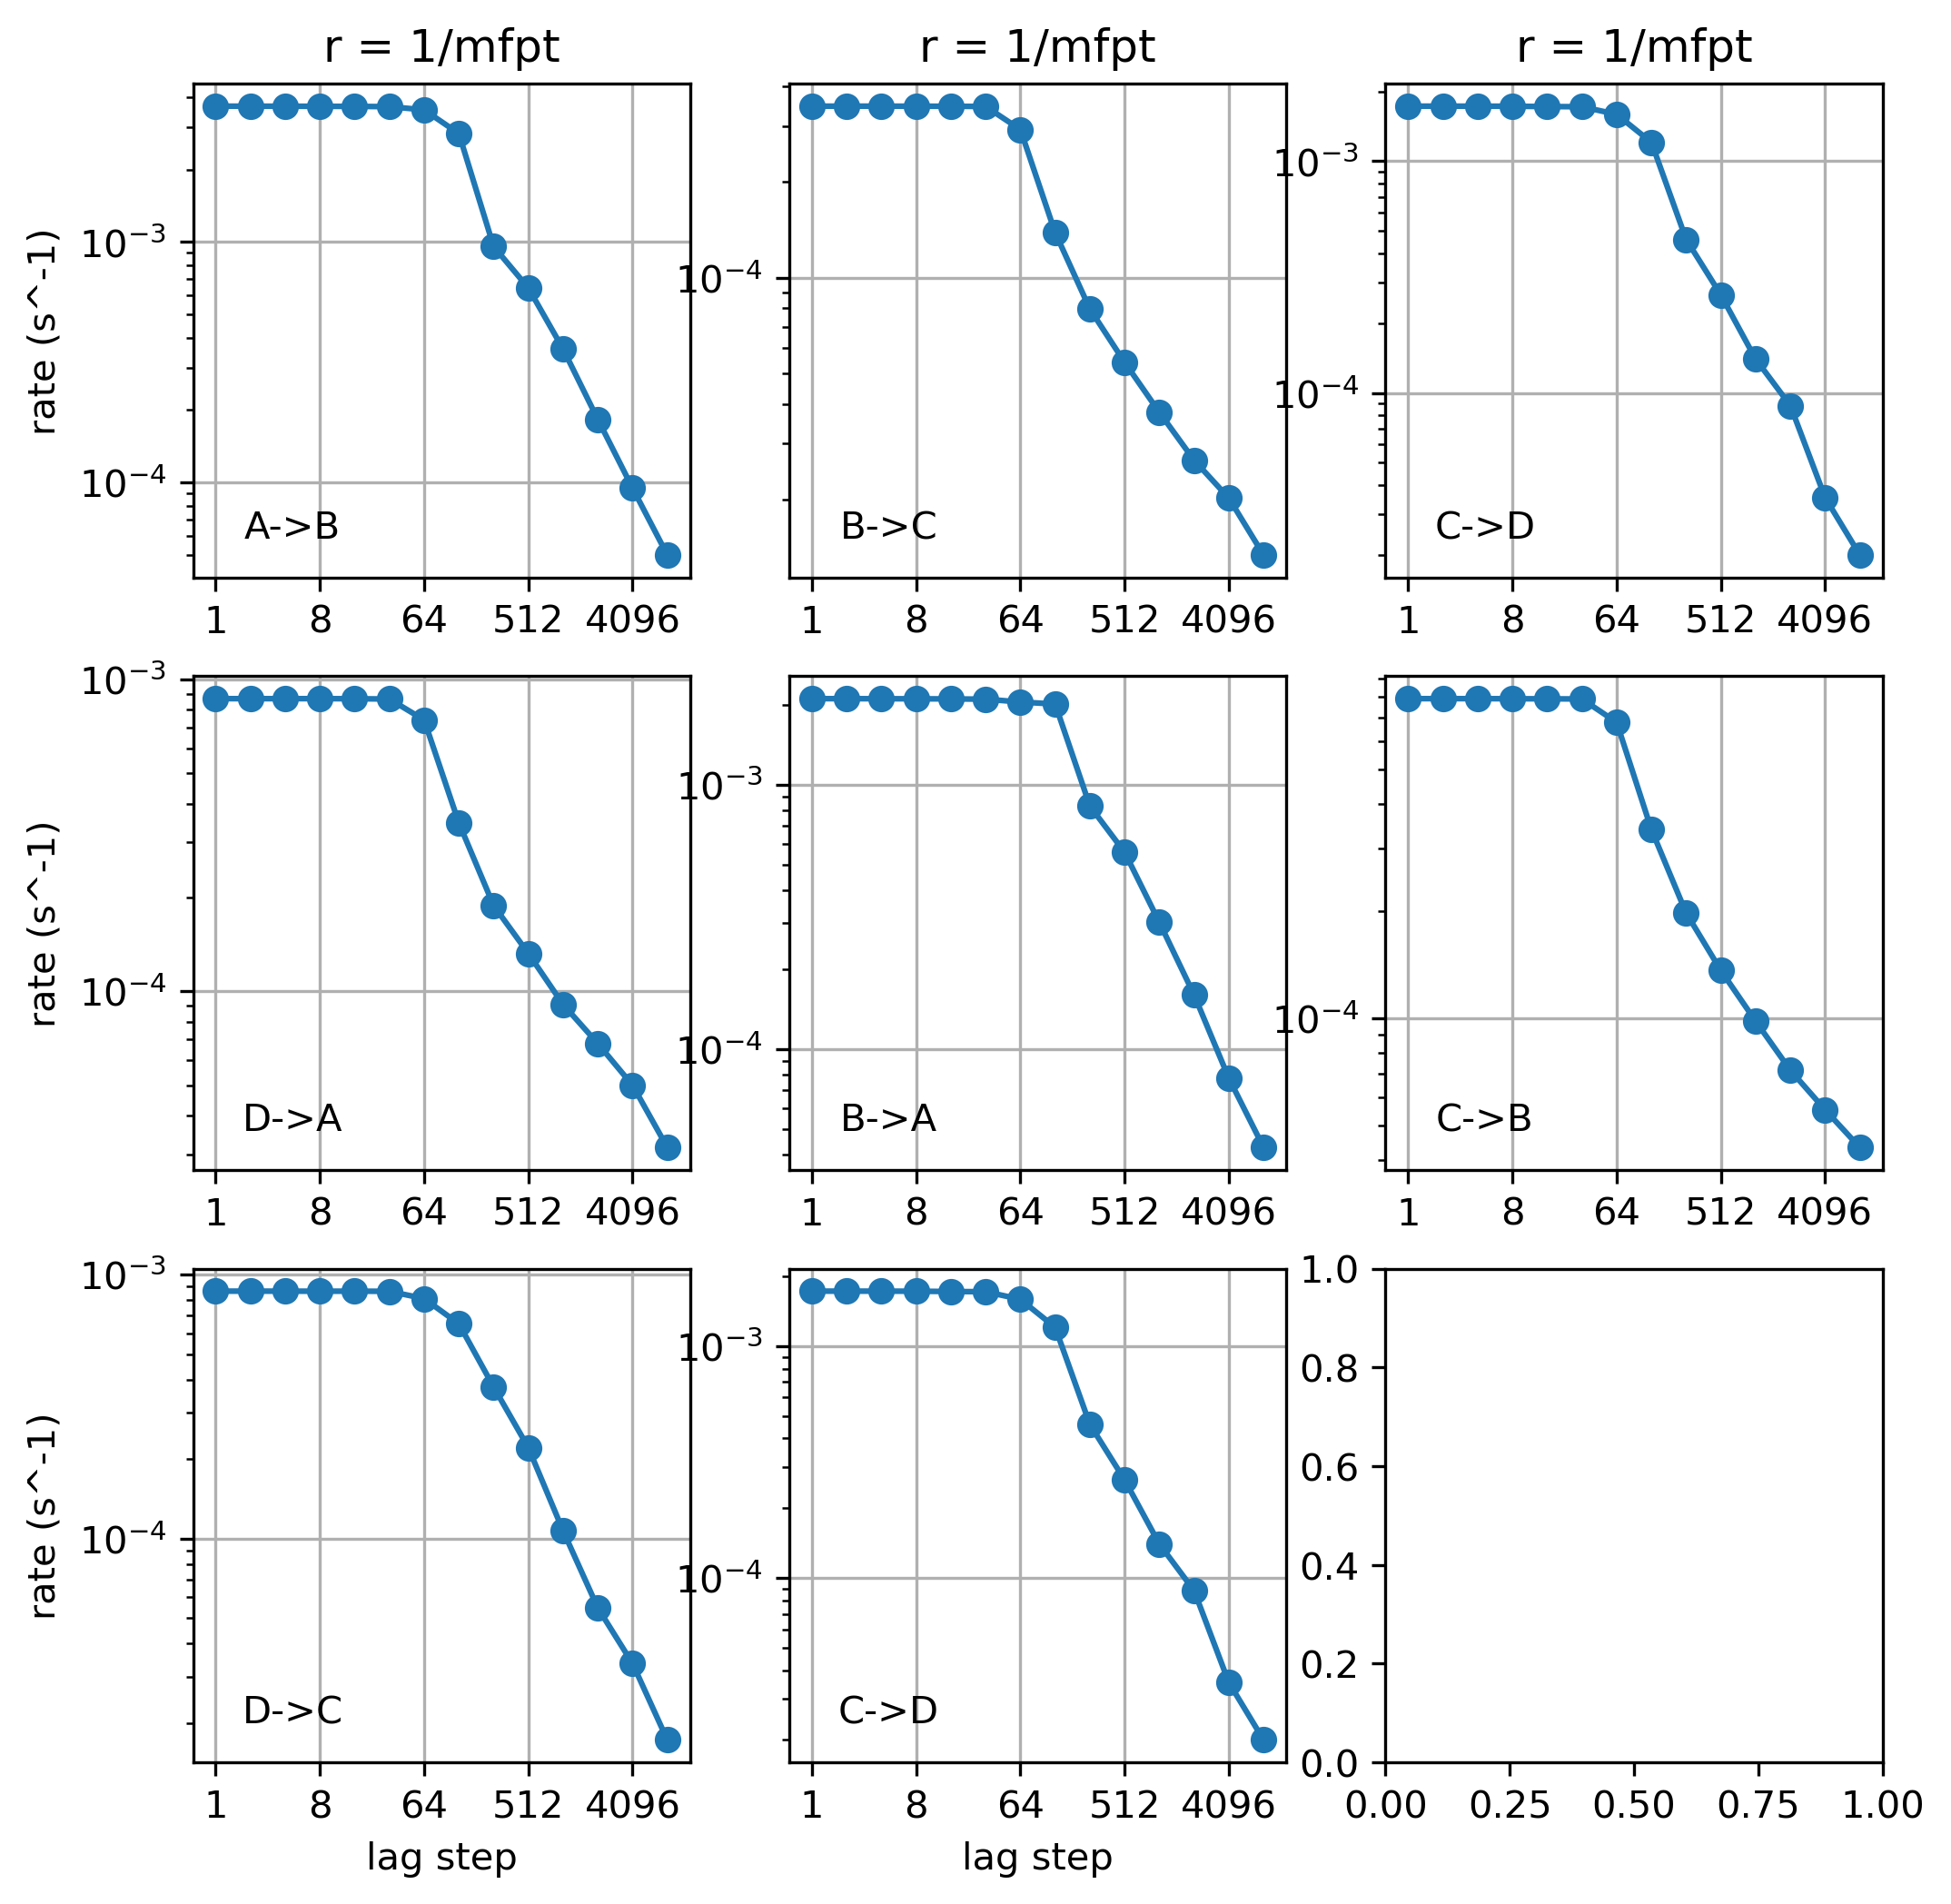

In [11]:
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6),
      (ax7, ax8, ax9)) = plt.subplots(3, 3, dpi=300, figsize=(8,8))
for b_name ,ax in zip(["A_B", "B_C", "C_D", "D_A", "B_A", "C_B", "D_C", "C_D"],
                      [  ax1,   ax2,   ax3,   ax4,   ax5,   ax6,   ax7,   ax8]):
    print(b_name)
    i_s, j_s = b_name.split("_")
    ax.plot(step_list, rate_mfpt[b_name], "o-")
    ax.grid()
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.text(0.2, 0.1, f"{i_s}->{j_s}", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xticks(step_list[::3], step_list[::3])
# final row
for ax in [ax7, ax8]:
    ax.set_xlabel("lag step")
    
for ax in [ax1, ax4, ax7]:
    ax.set_ylabel("rate (s^-1)")
    
for ax in [ax1, ax2, ax3]:
    ax.set_title("r = 1/mfpt")

A_B
B_C
C_D
D_A
B_A
C_B
D_C
C_D


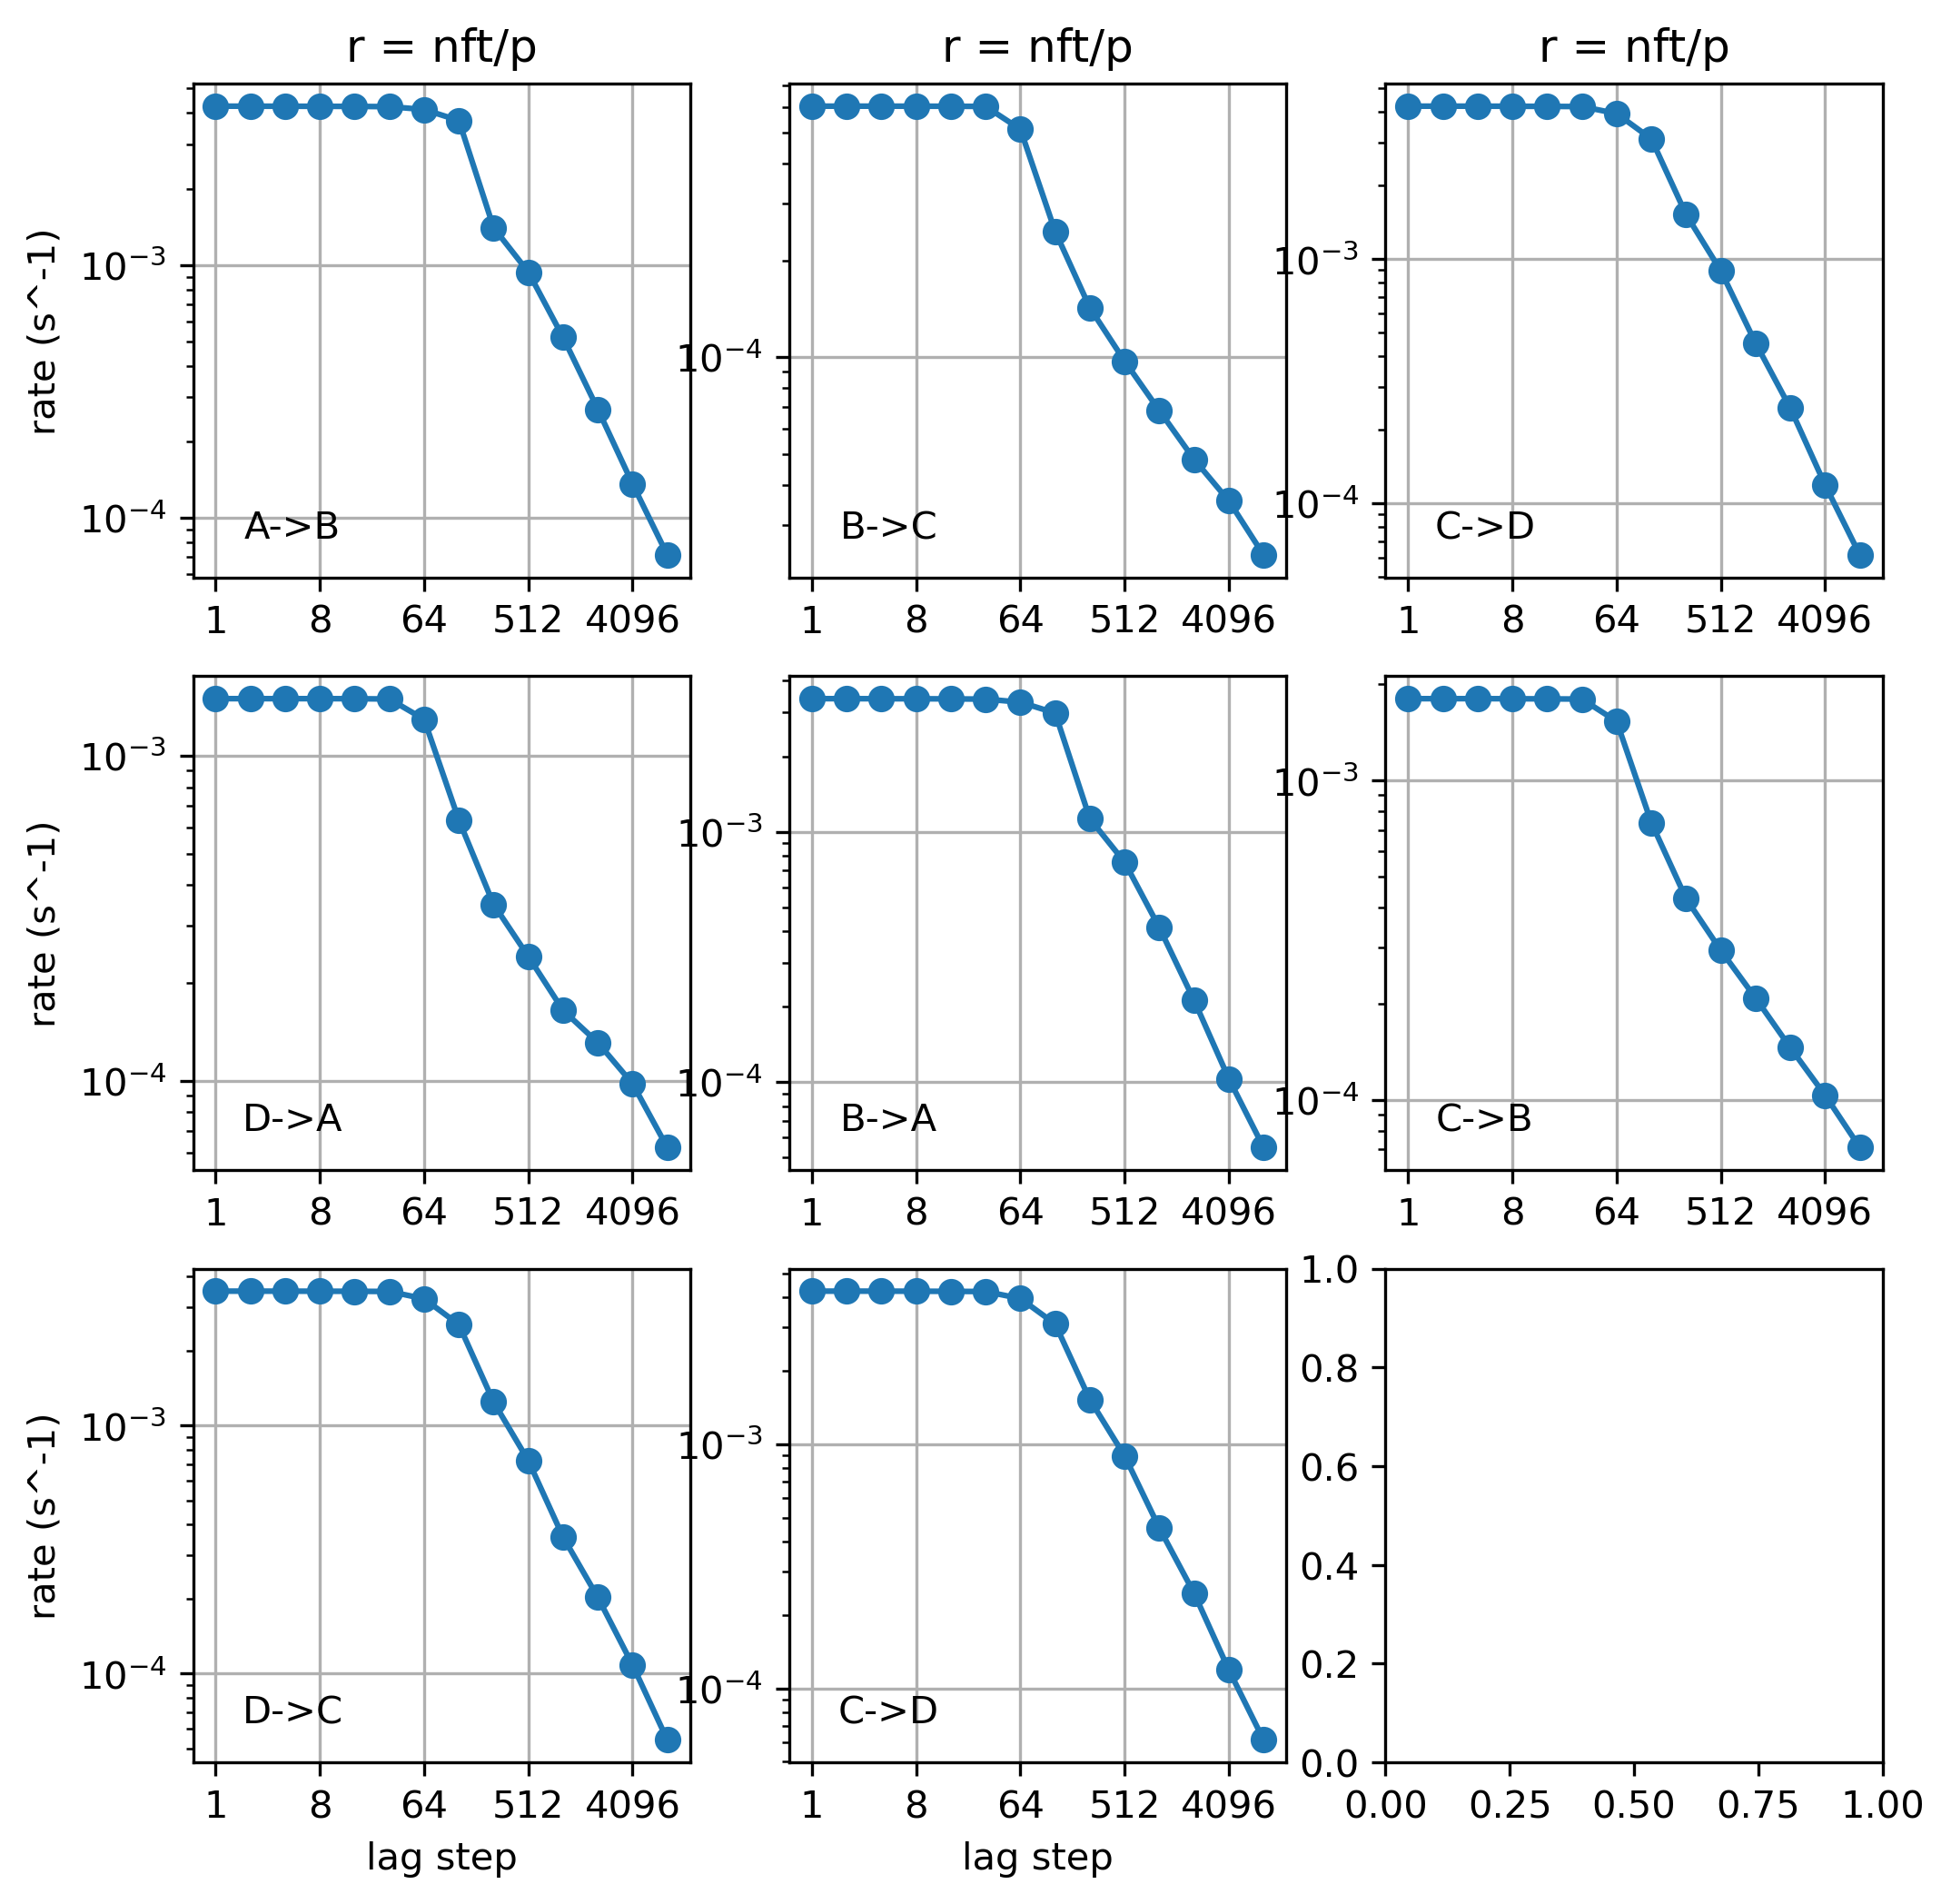

In [12]:
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6),
      (ax7, ax8, ax9)) = plt.subplots(3, 3, dpi=300, figsize=(8,8))
for b_name ,ax in zip(["A_B", "B_C", "C_D", "D_A", "B_A", "C_B", "D_C", "C_D"],
                      [  ax1,   ax2,   ax3,   ax4,   ax5,   ax6,   ax7,   ax8]):
    print(b_name)
    i_s, j_s = b_name.split("_")
    ax.plot(step_list, rate_nft[b_name], "o-")
    ax.grid()
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.text(0.2, 0.1, f"{i_s}->{j_s}", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xticks(step_list[::3], step_list[::3])
# final row
for ax in [ax7, ax8]:
    ax.set_xlabel("lag step")
    
for ax in [ax1, ax4, ax7]:
    ax.set_ylabel("rate (s^-1)")
    
for ax in [ax1, ax2, ax3]:
    ax.set_title("r = nft/p")

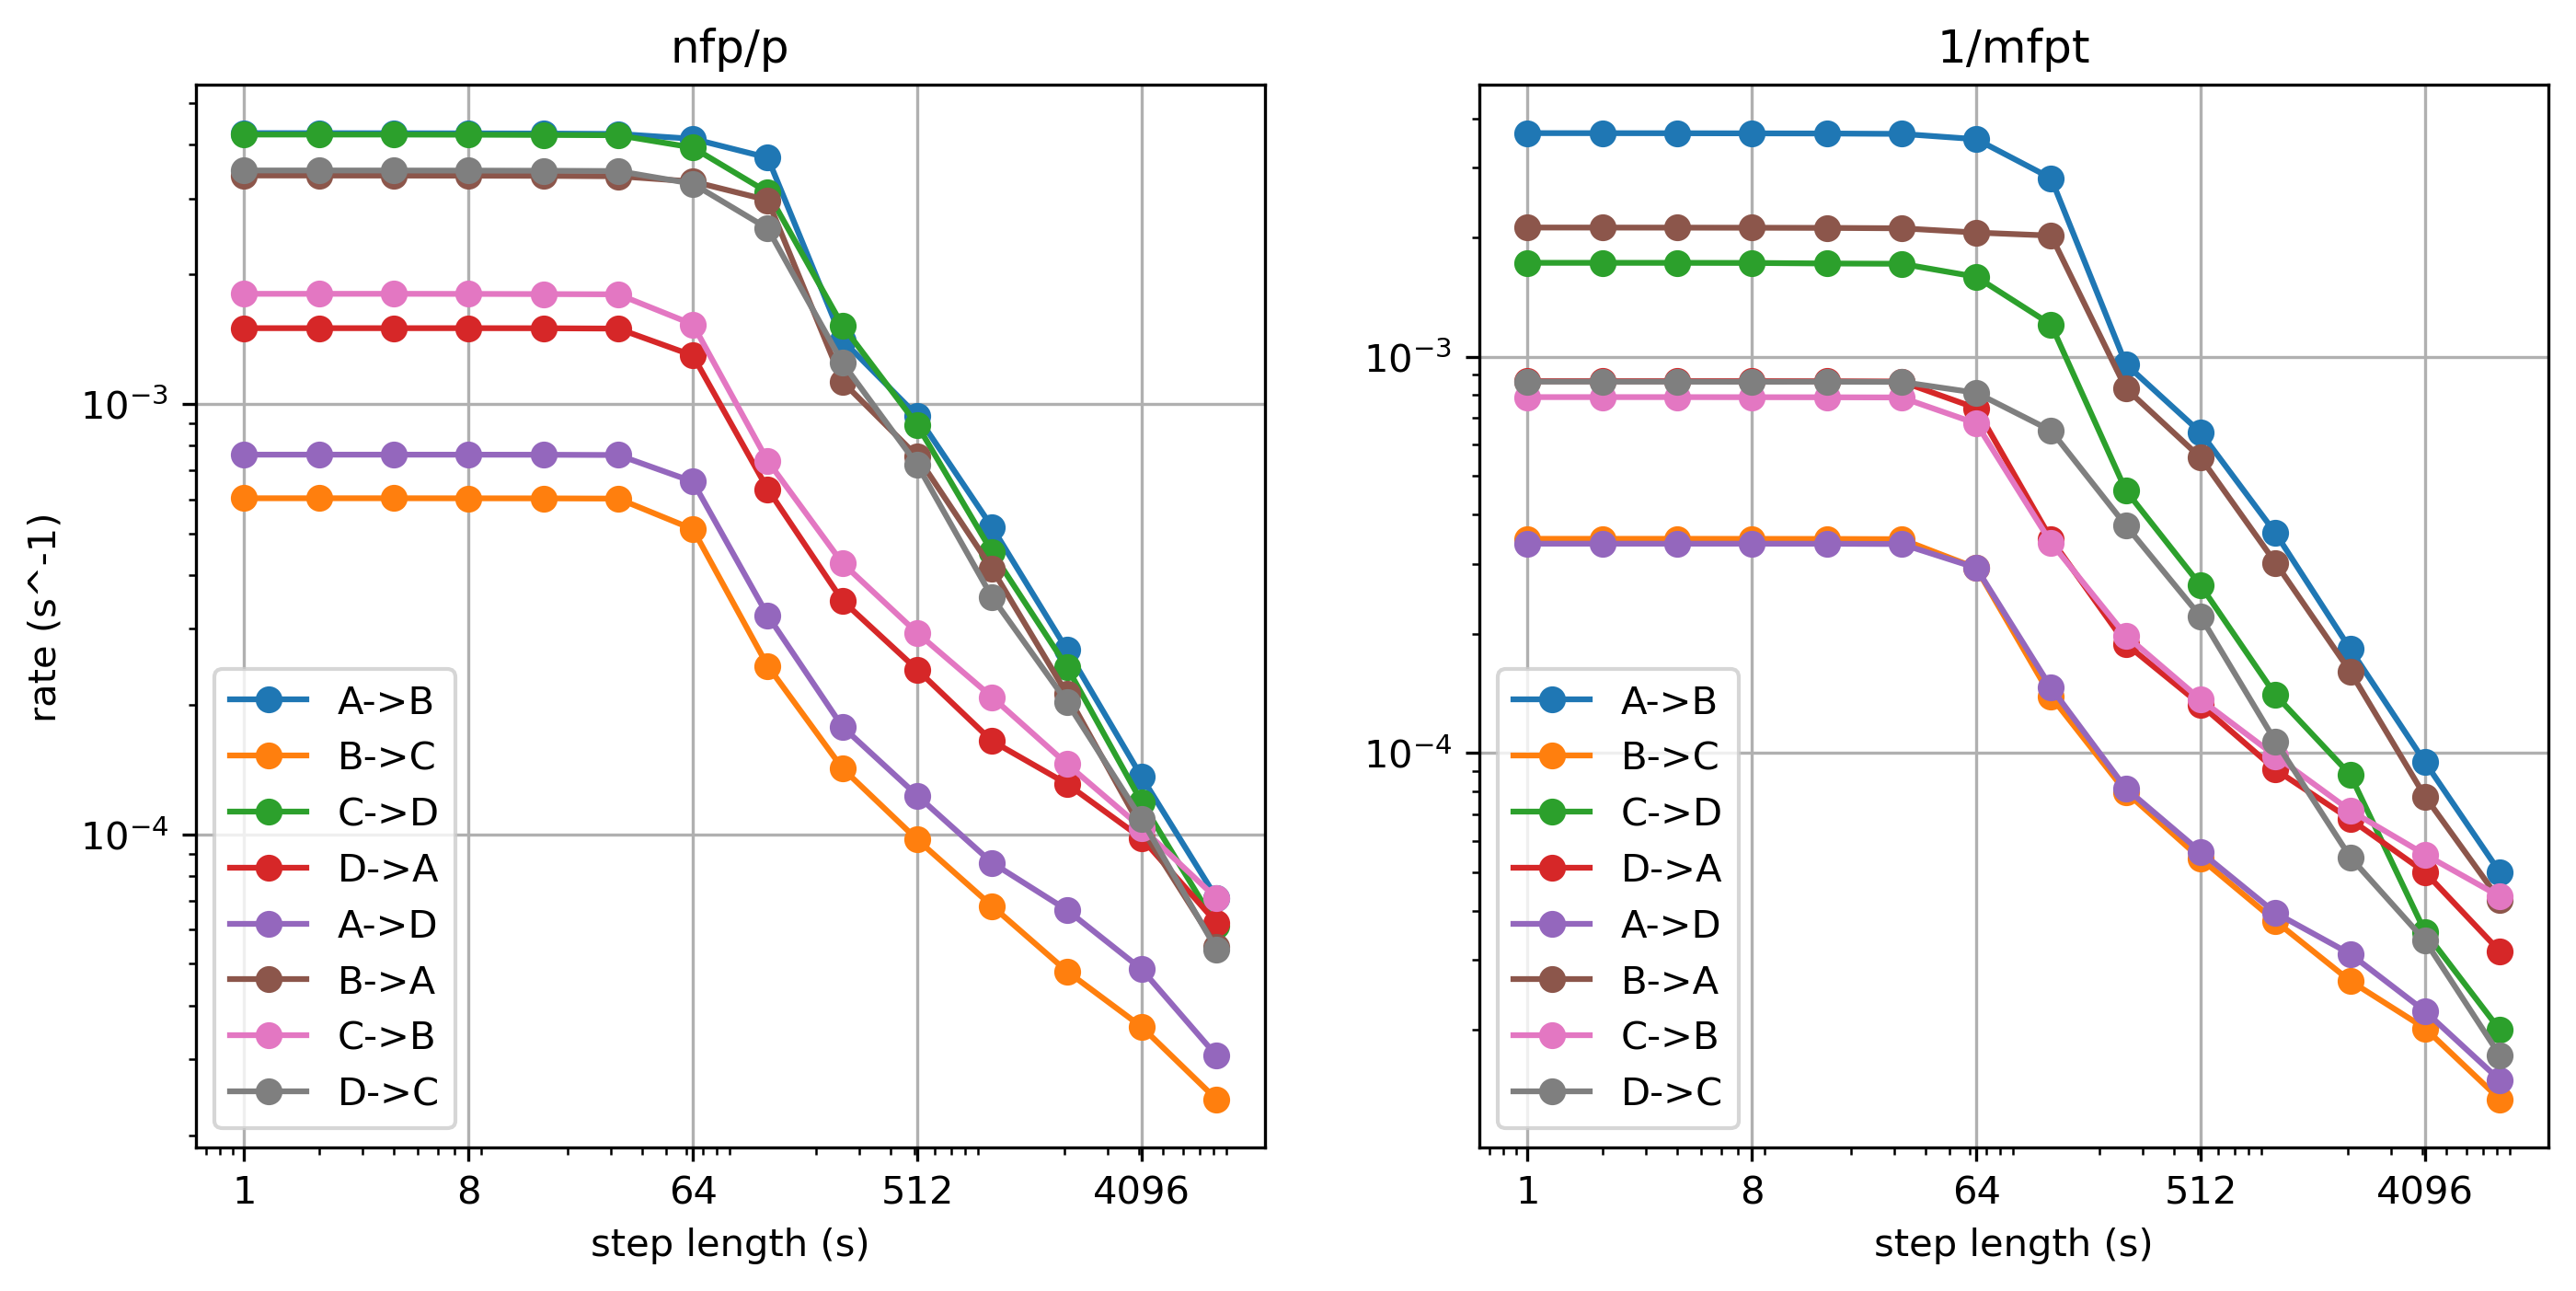

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(11,5))
for b_name in barrier_ref:
    i_s, j_s = b_name.split("_")
    ax1.plot(step_list, rate_nft[b_name], "o-"  ,label=f"{i_s}->{j_s}")
    ax2.plot(step_list, rate_mfpt[b_name], "o-" ,label=f"{i_s}->{j_s}")

for ax in [ax1, ax2]:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks(step_list[::3], step_list[::3])
    ax.set_xlabel("step length (s)")
    ax.grid()
    ax.legend()
    
ax1.set_title("nfp/p")
ax2.set_title("1/mfpt")
ax1.set_ylabel("rate (s^-1)")
plt.savefig("rate_step.png")

In [60]:
def linear_regression(ax1, x_data, y_data):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    x_min, x_max = ax1.get_xlim()
    y_min, y_max = ax1.get_ylim()
    ax1.text(0.6, 0.9, f"r = {r_value:.2f} \np = {p_value:.2f}\ny={slope:5.2f}*x {intercept:+5.2f}",
            verticalalignment='center',
            transform=ax1.transAxes)
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = slope * x_line + intercept
    ax1.plot(x_line, y_line)
    
def increase_ylim(ax1):
    y1,y2 = ax1.get_ylim()
    ax1.set_ylim(y1,y2+(y2-y1)*0.2)

def scatter_all_barrier(ax1, barrier_ref, b_name, step_index, rate_data):
    x_data = []
    y_data = []
    for b_name in barrier_ref:
        x = barrier_ref[b_name]
        y = np.log(rate_data[b_name][step_index])
        ax1.scatter(x,y)
        x_data.append(x)
        y_data.append(y)
        ax1.text(x,y,b_name)
    return x_data, y_data

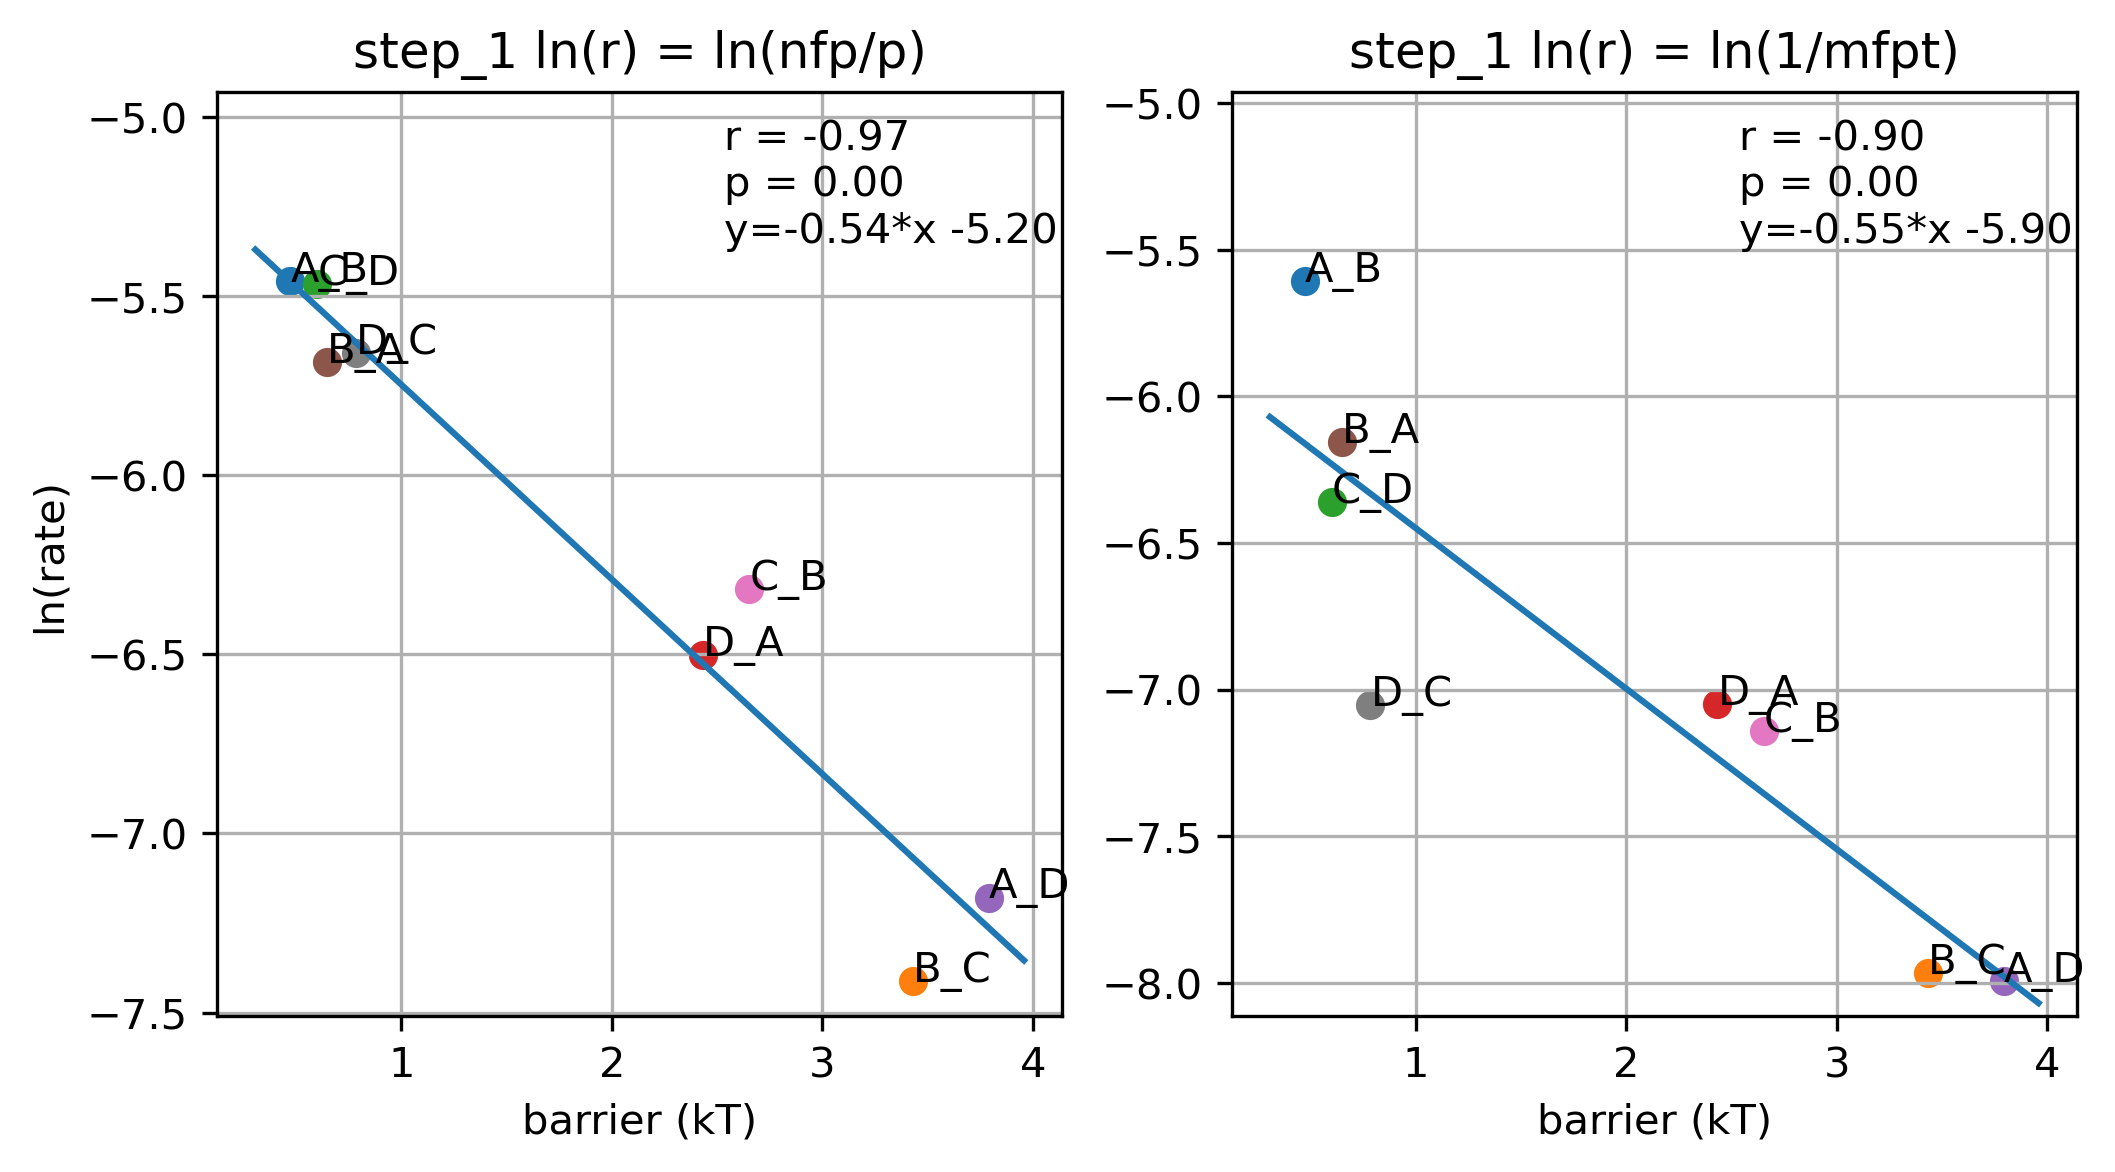

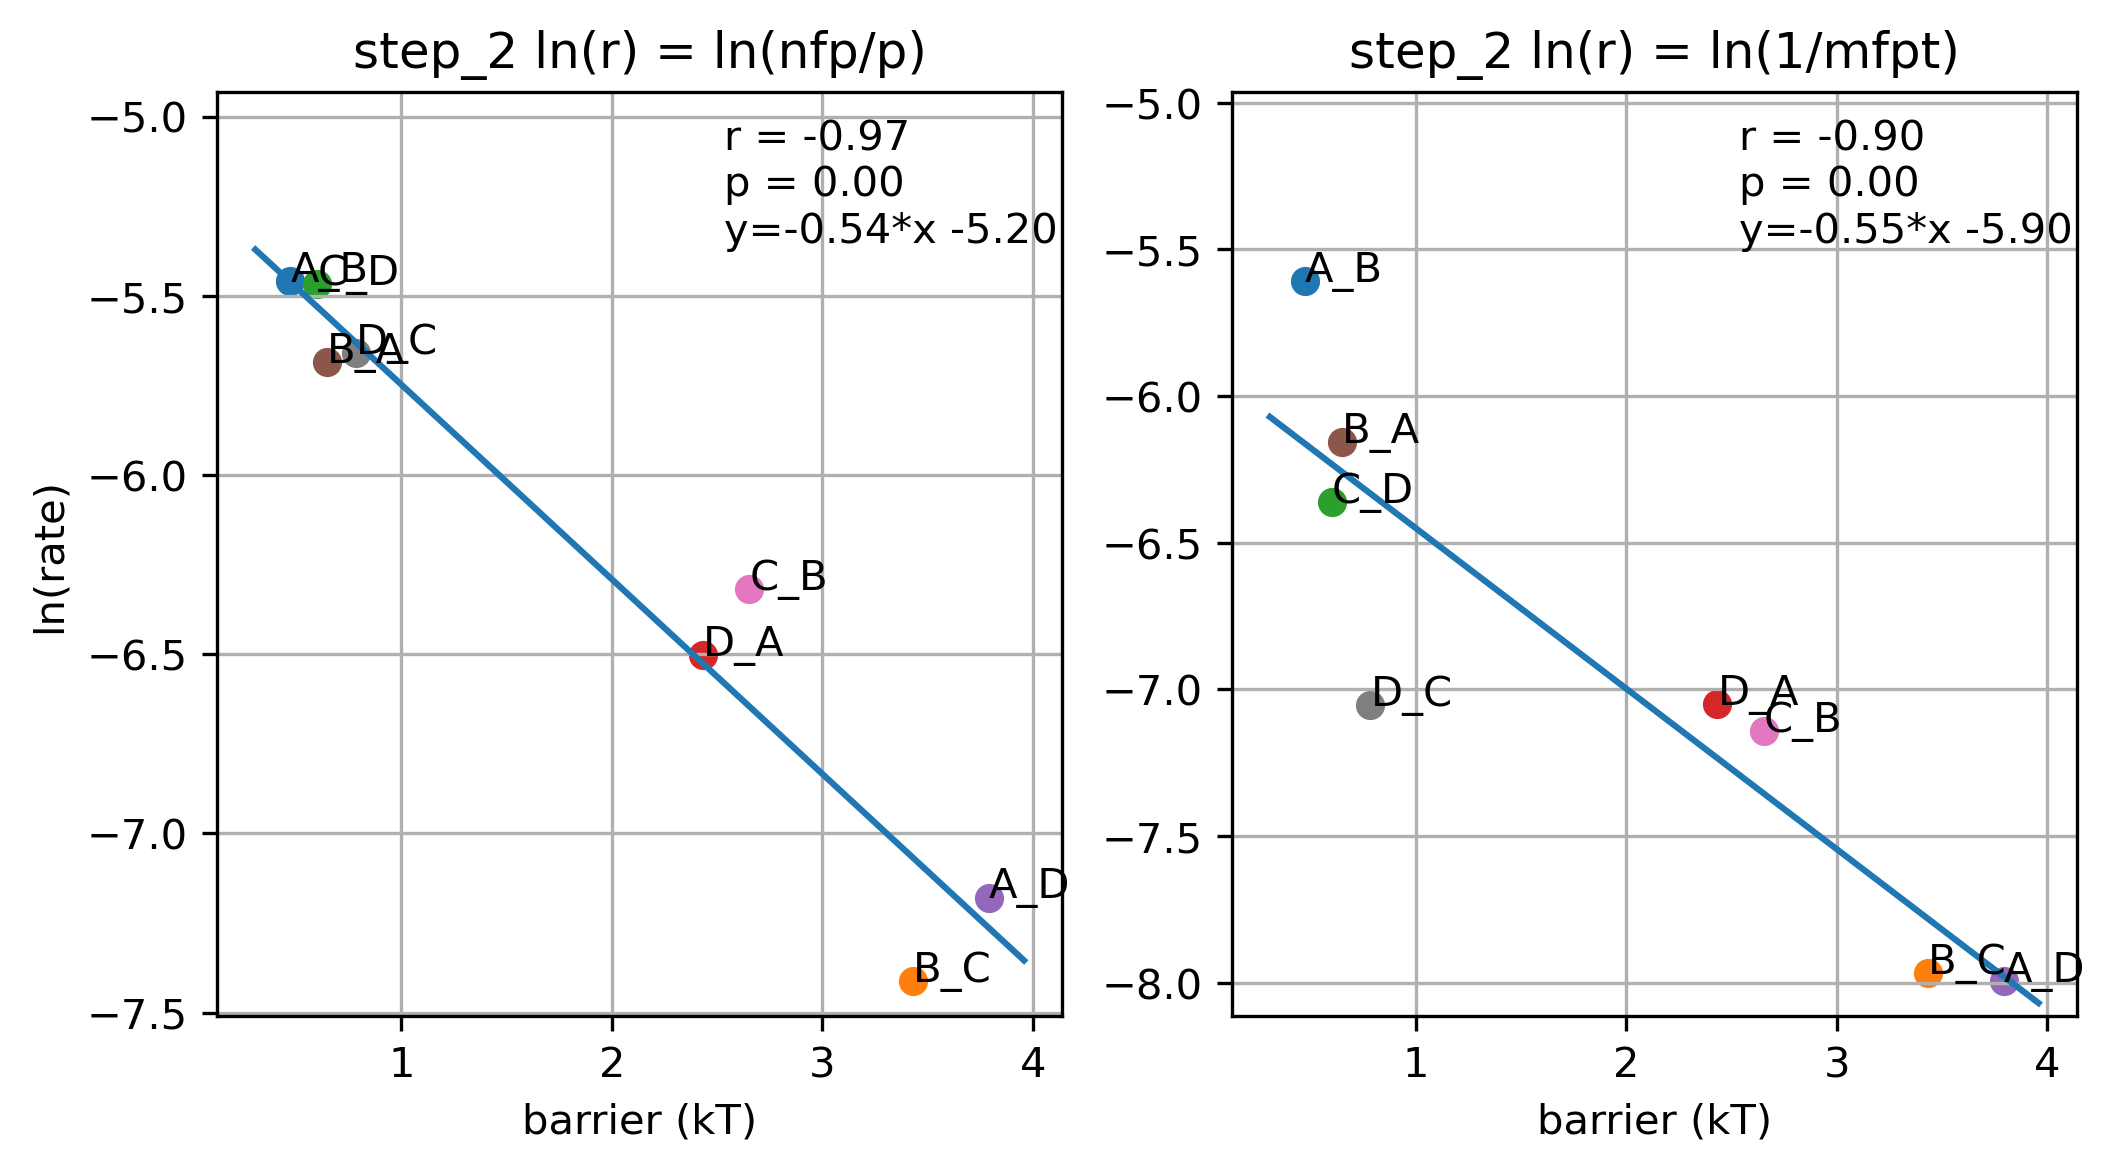

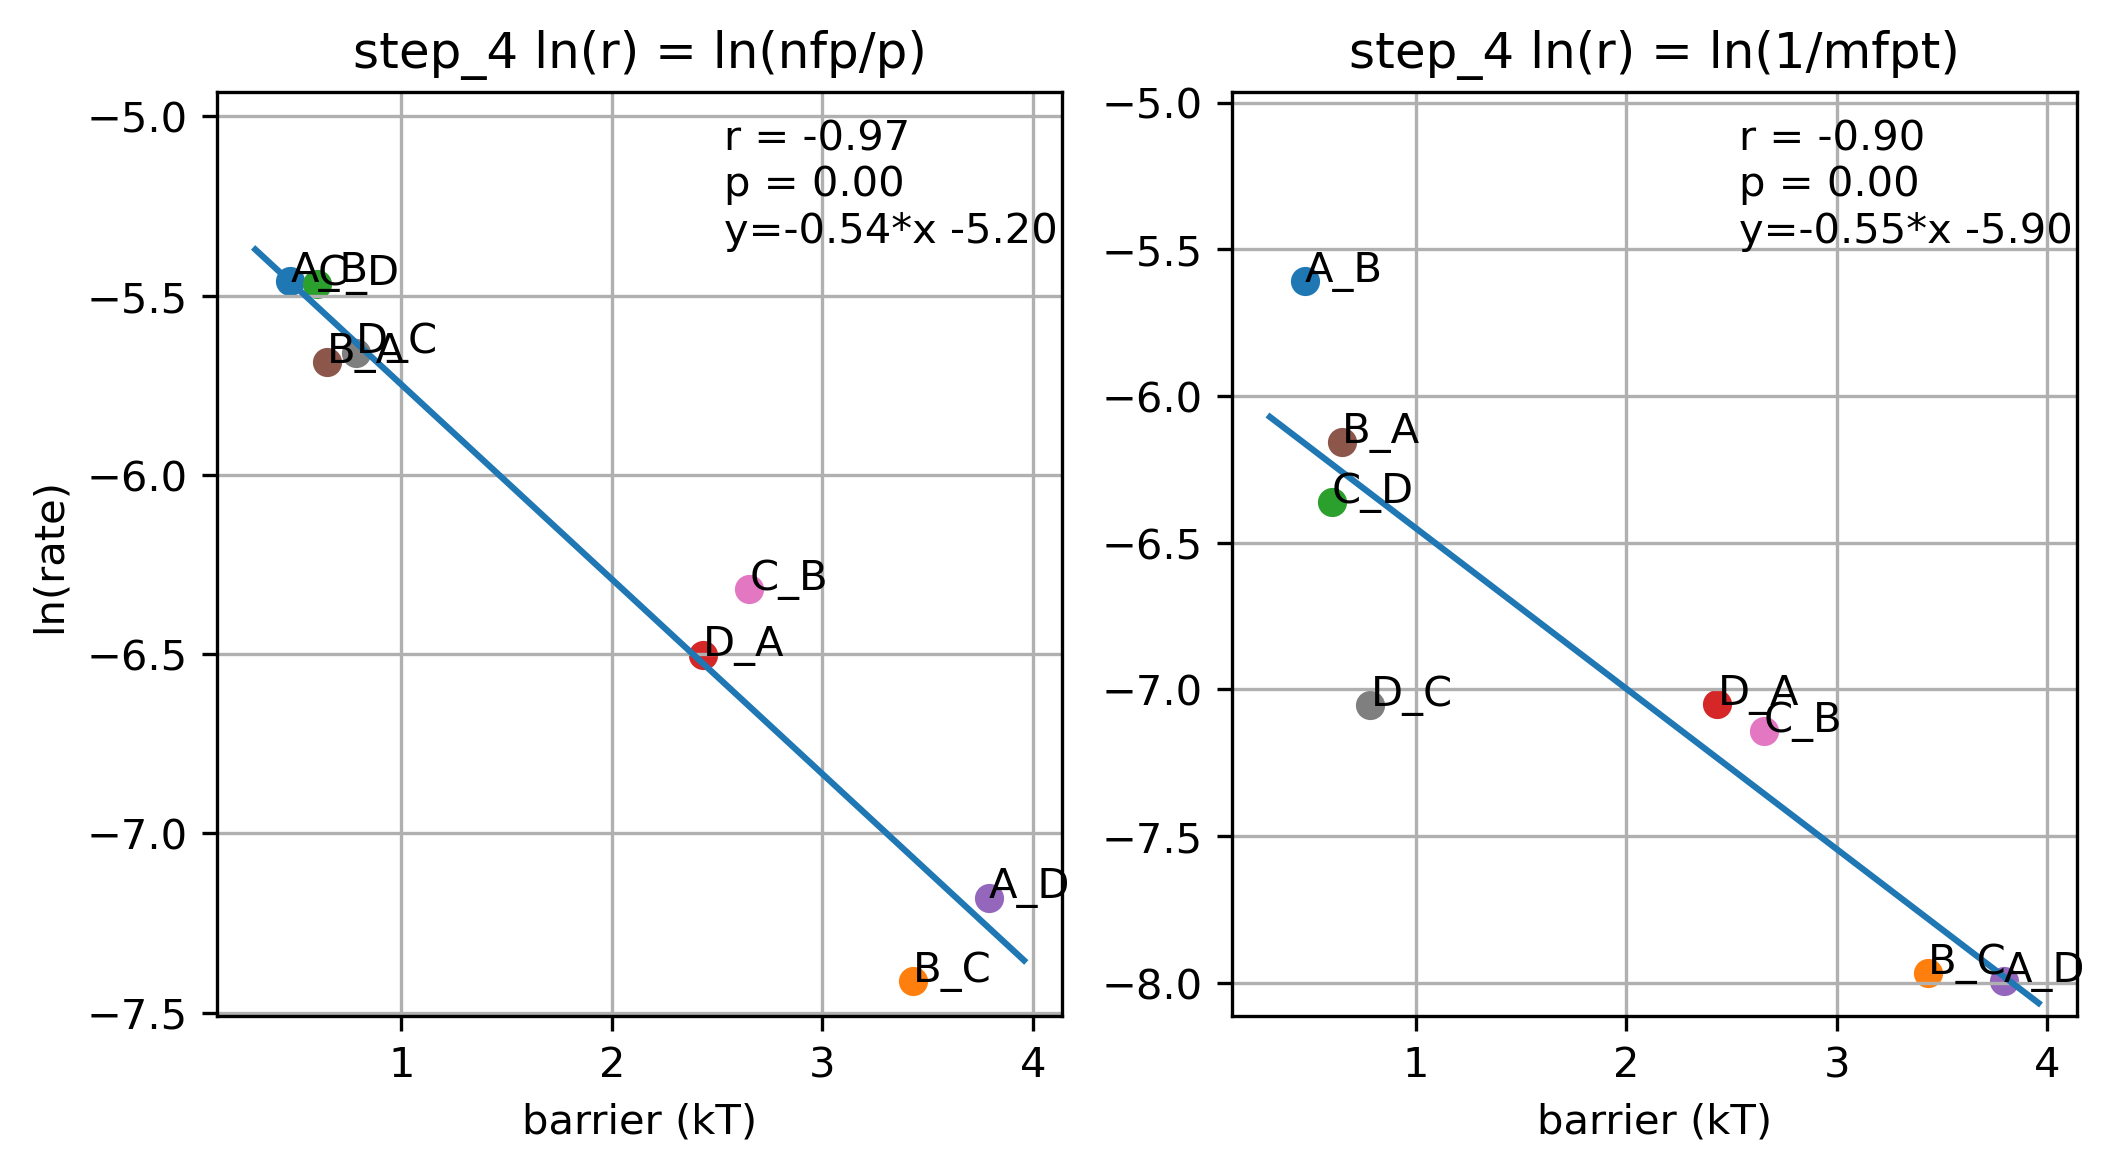

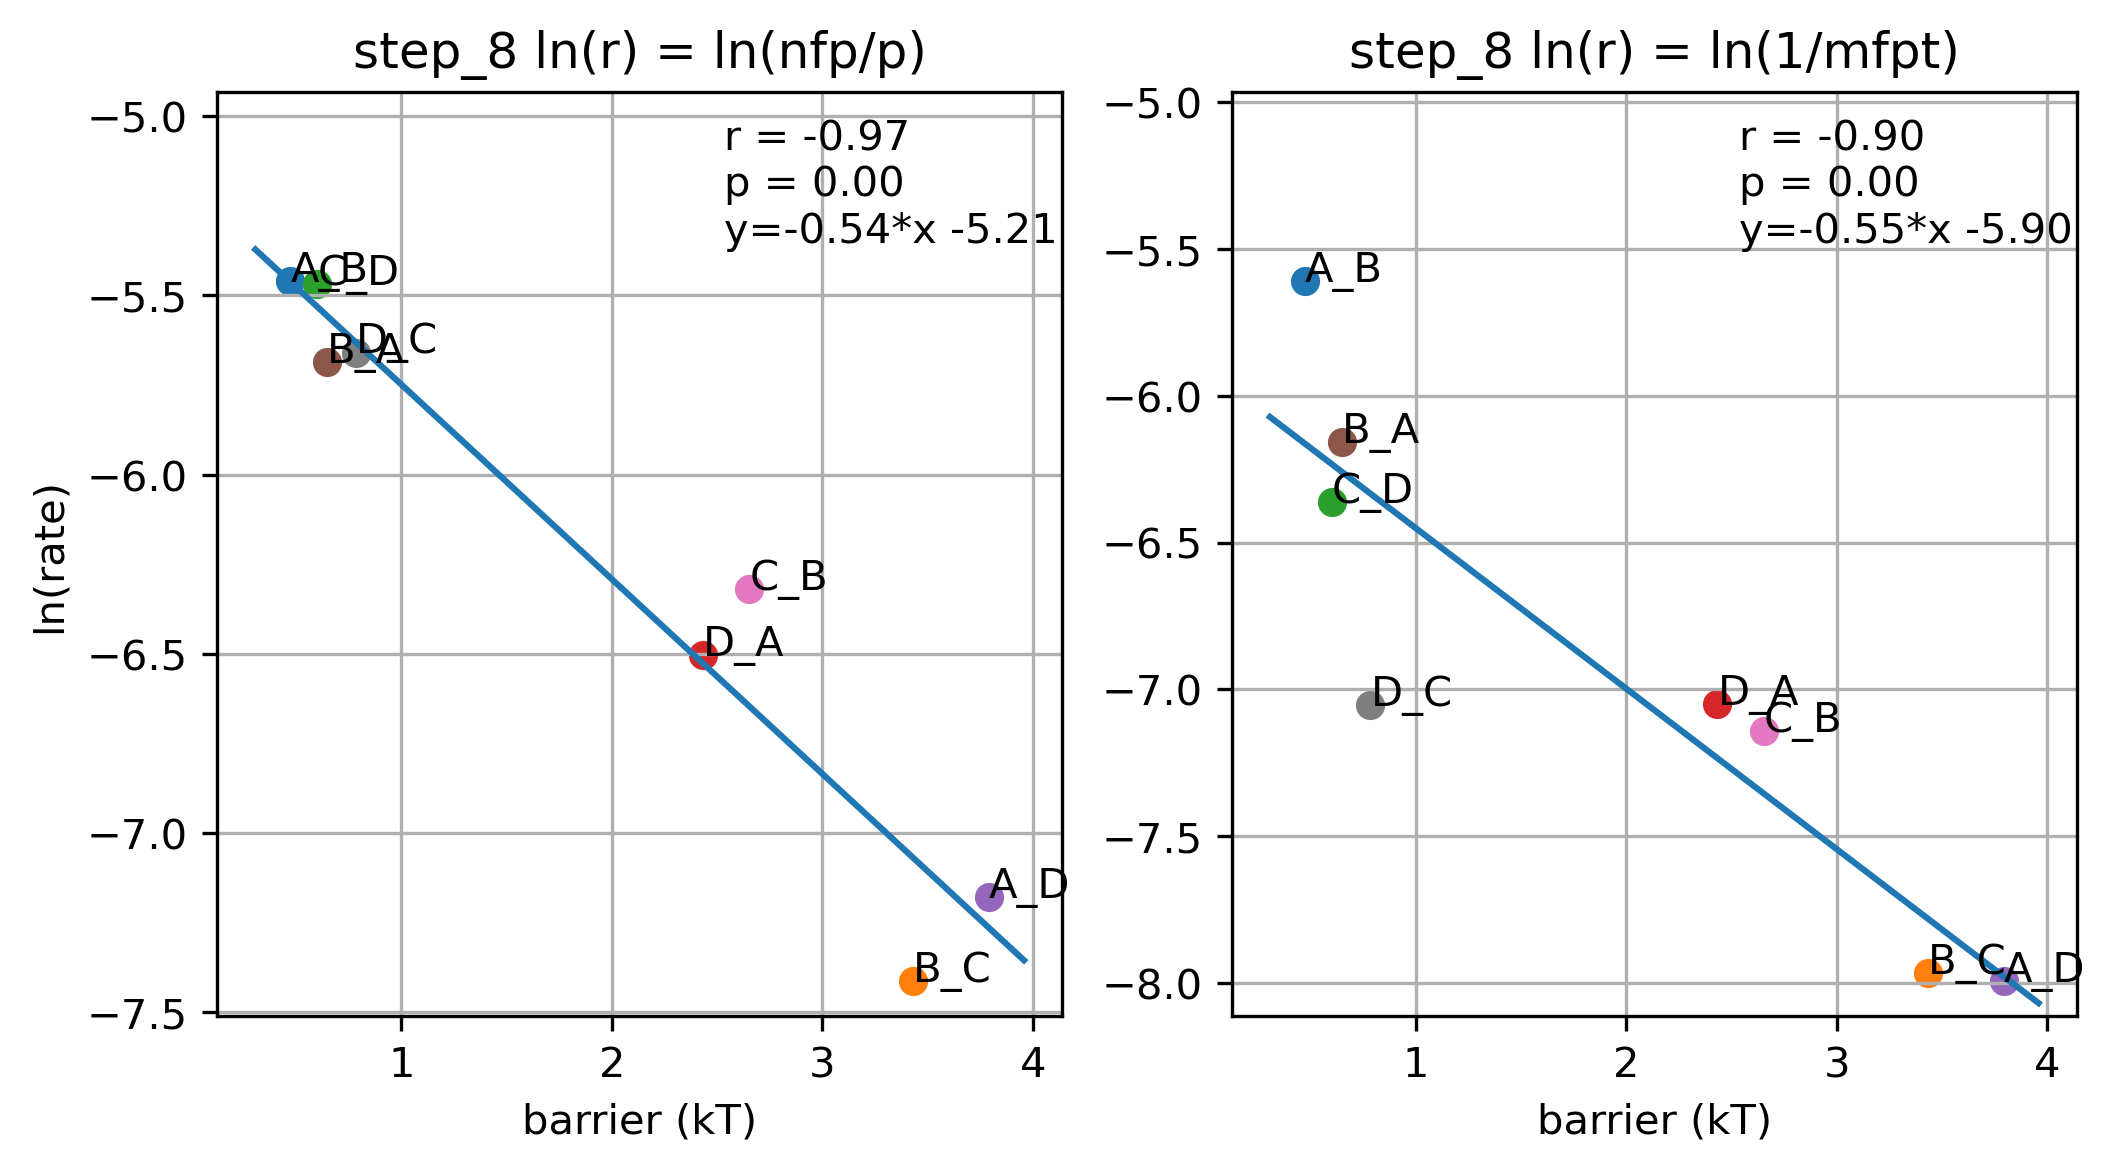

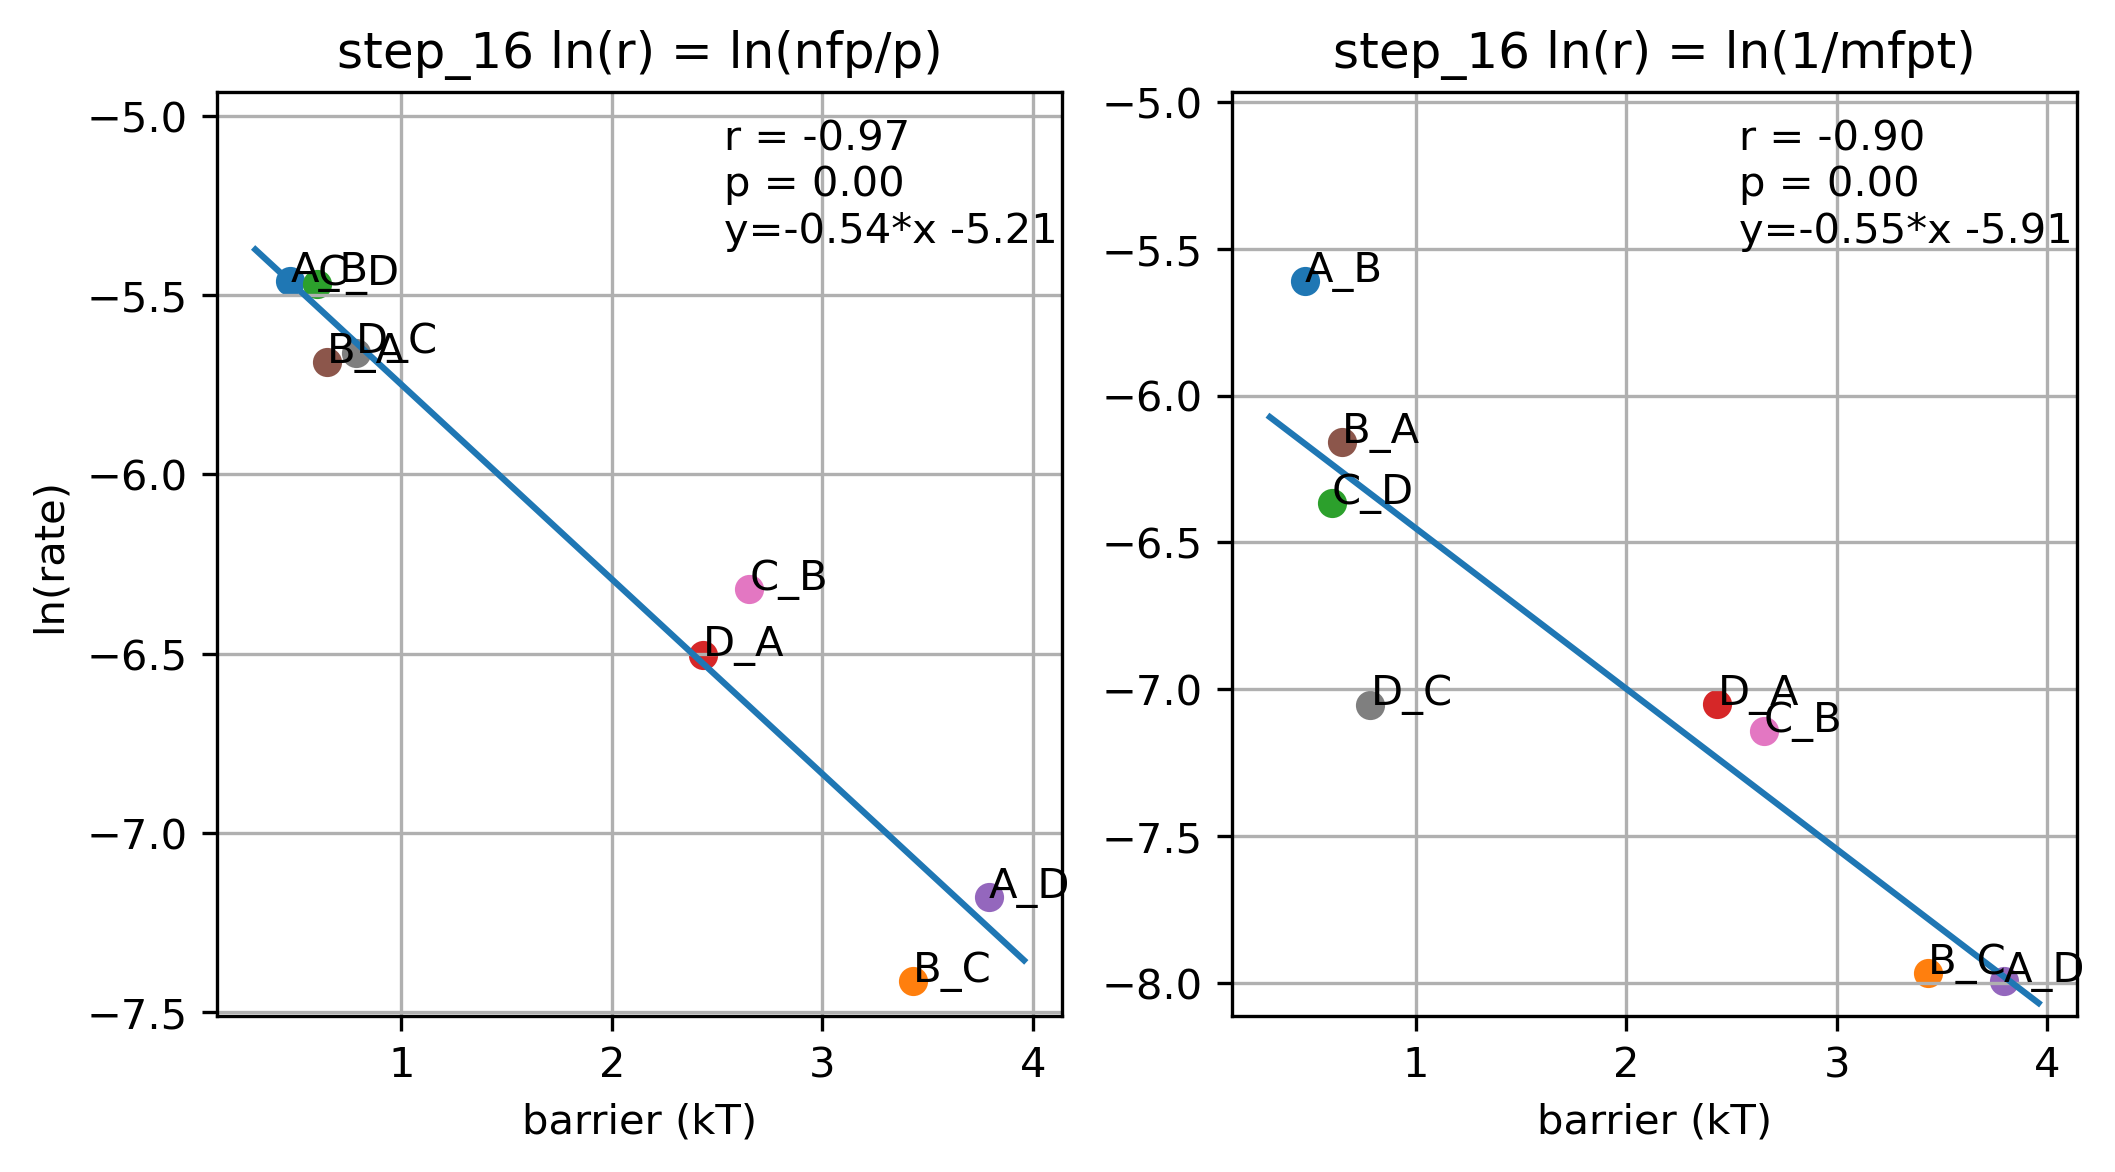

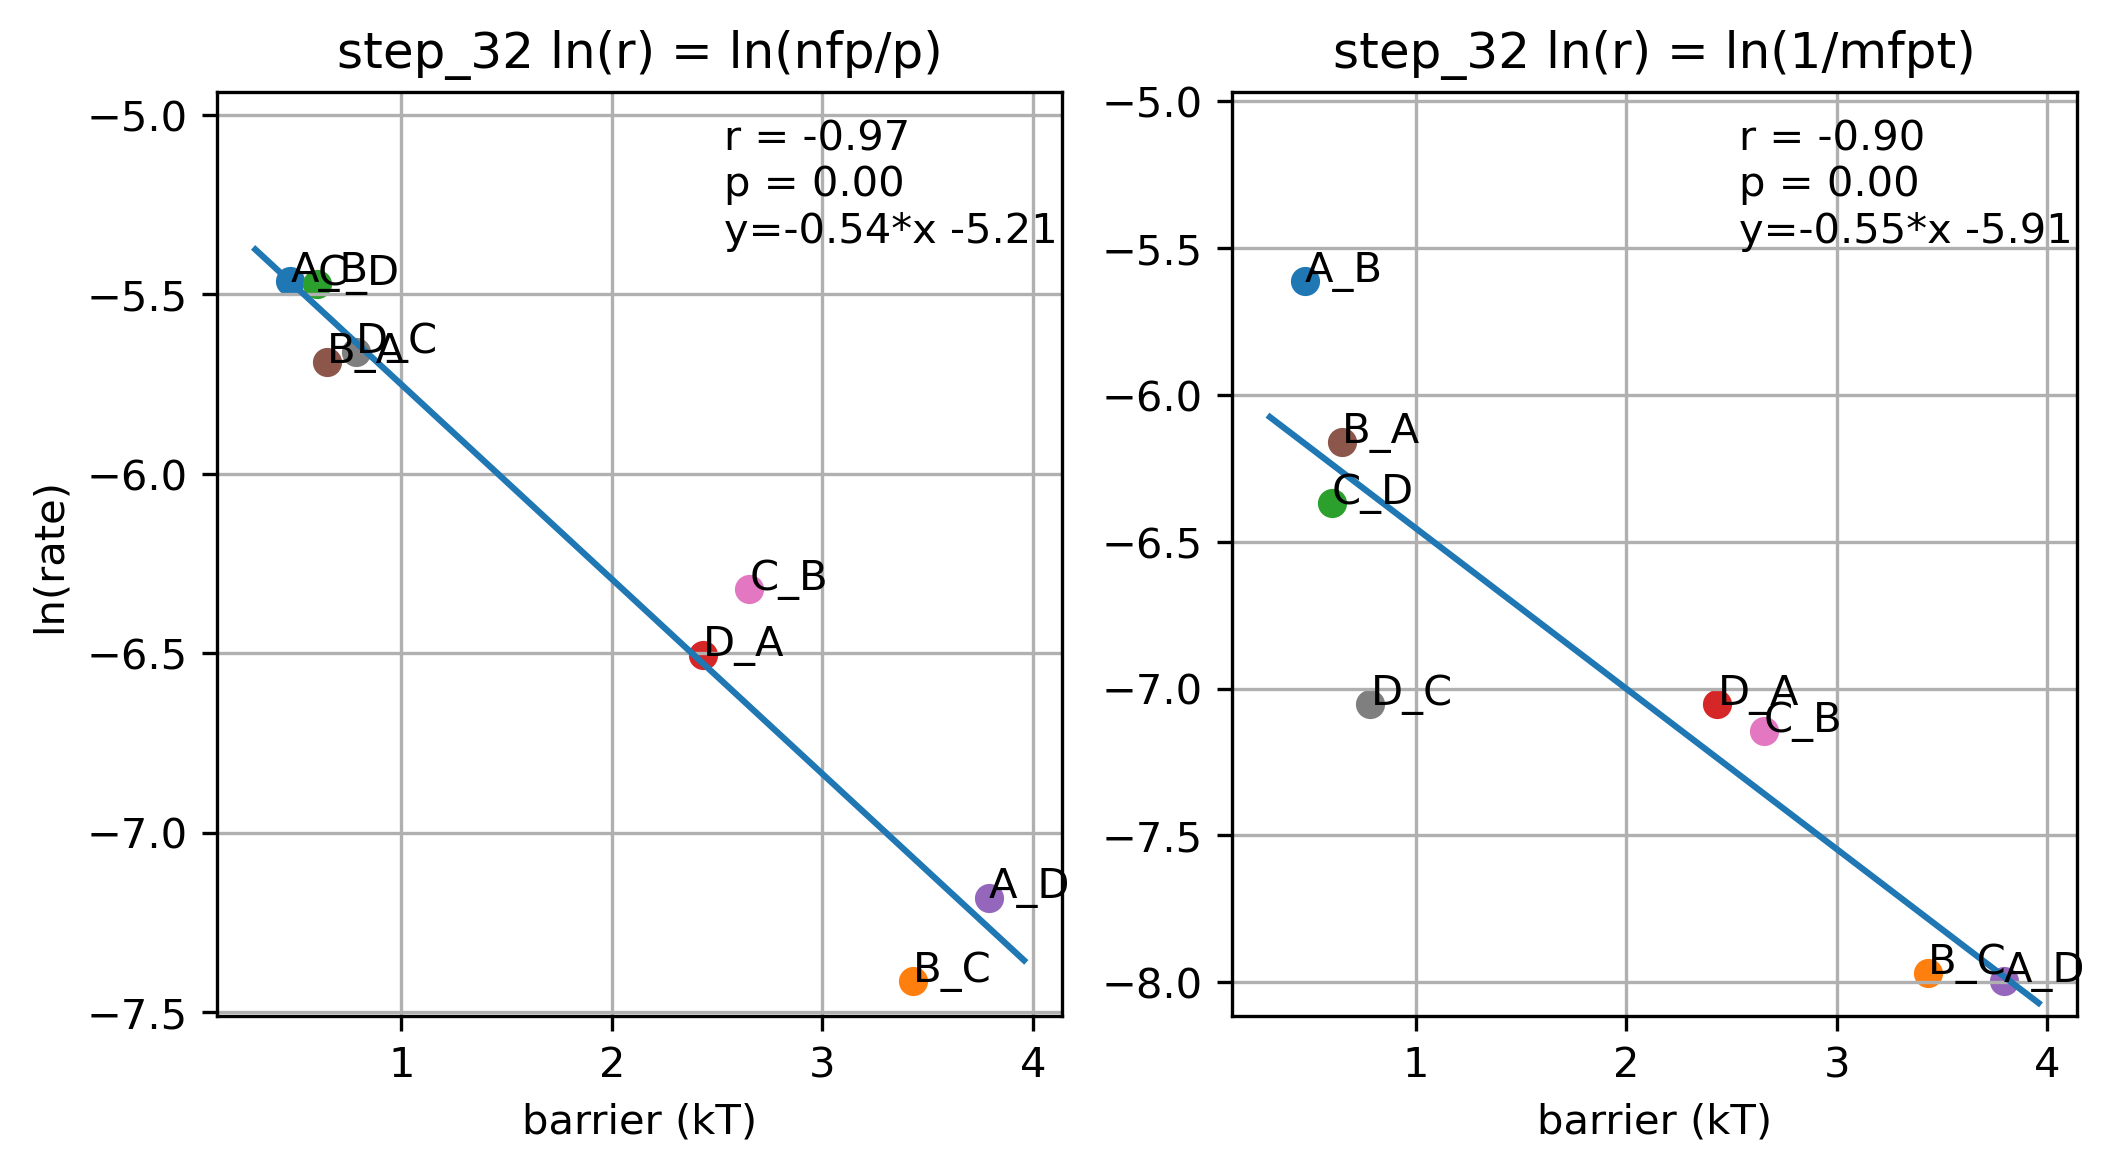

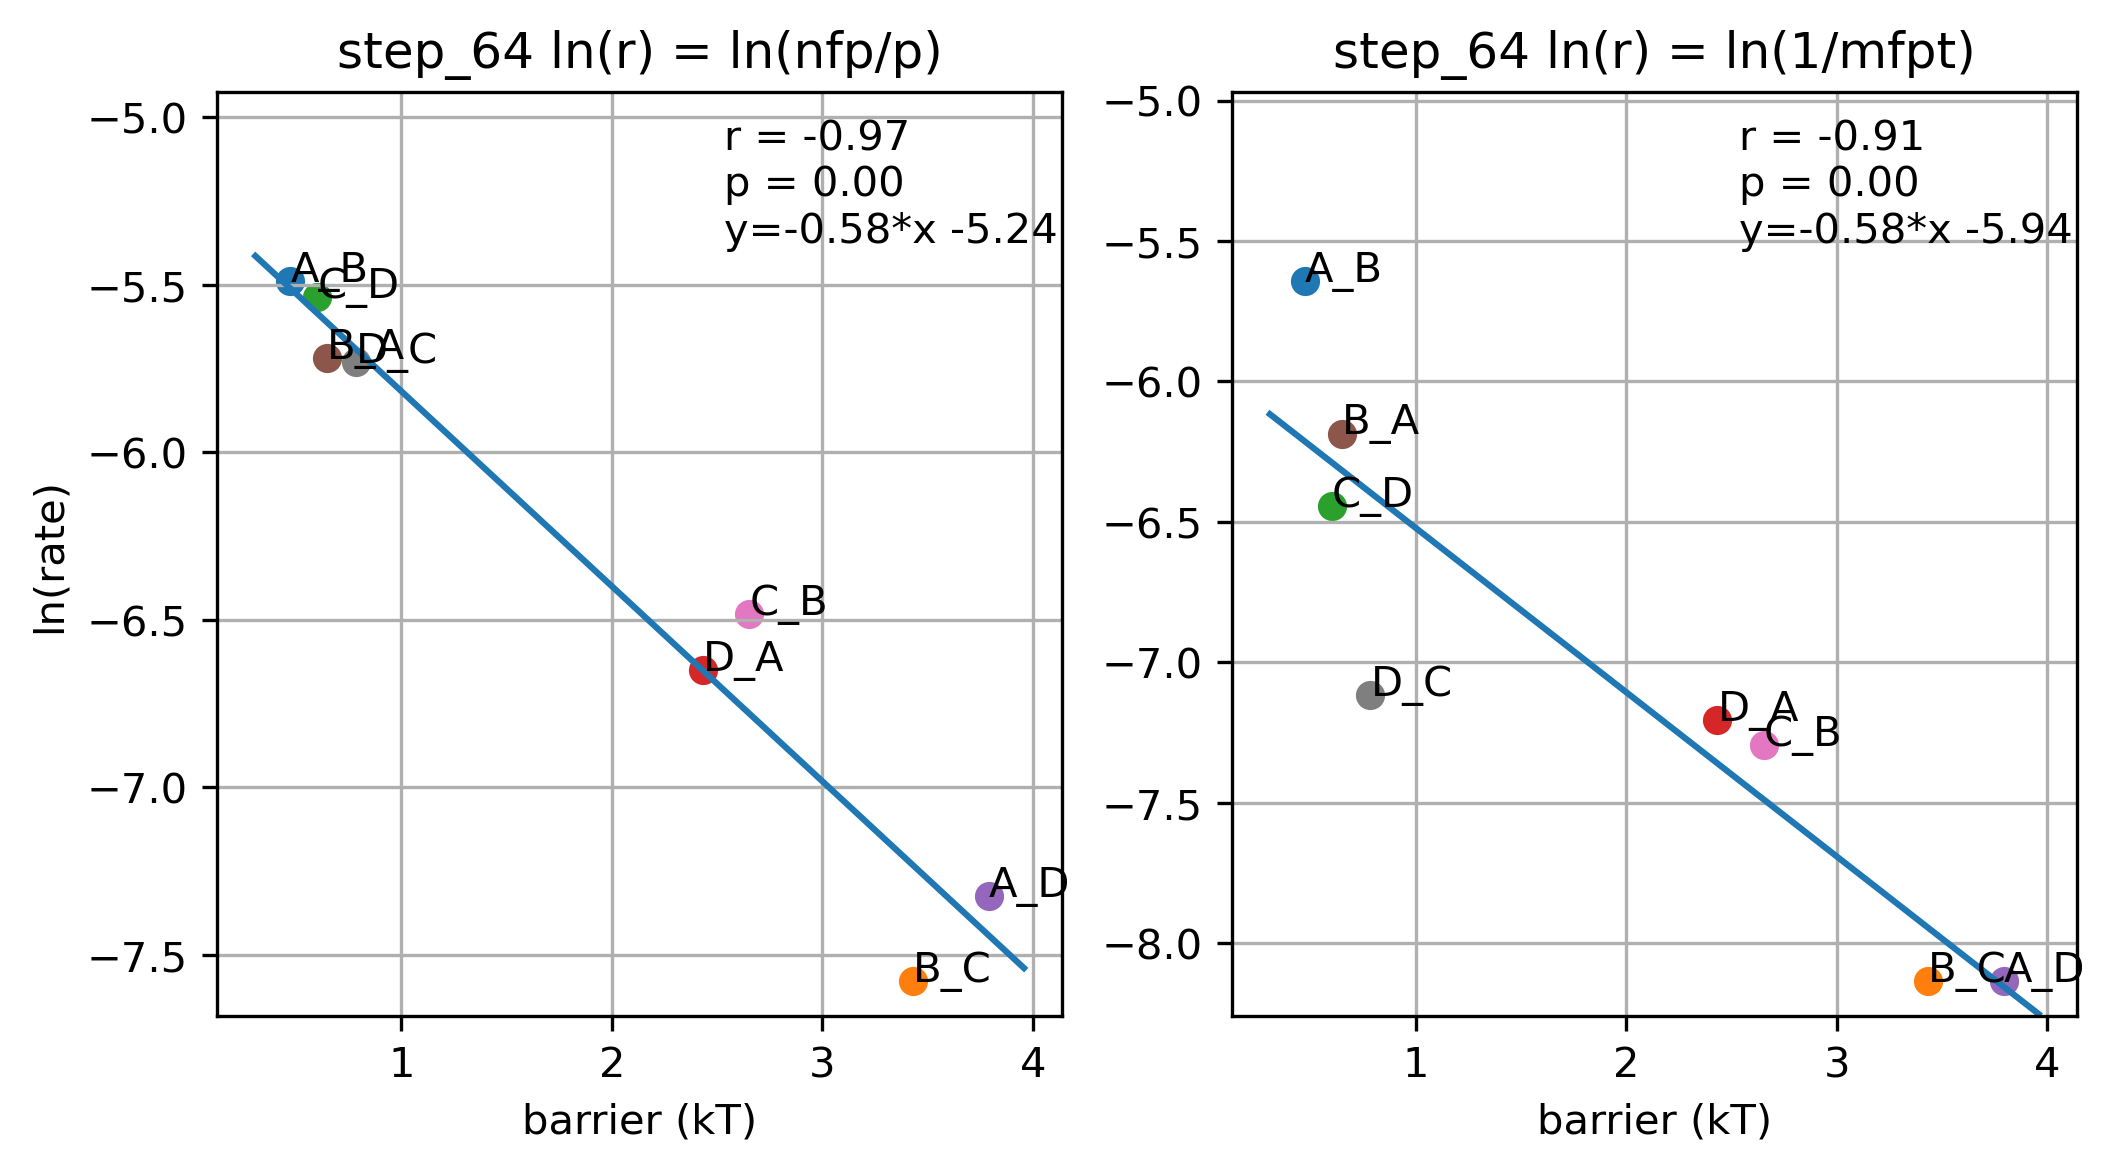

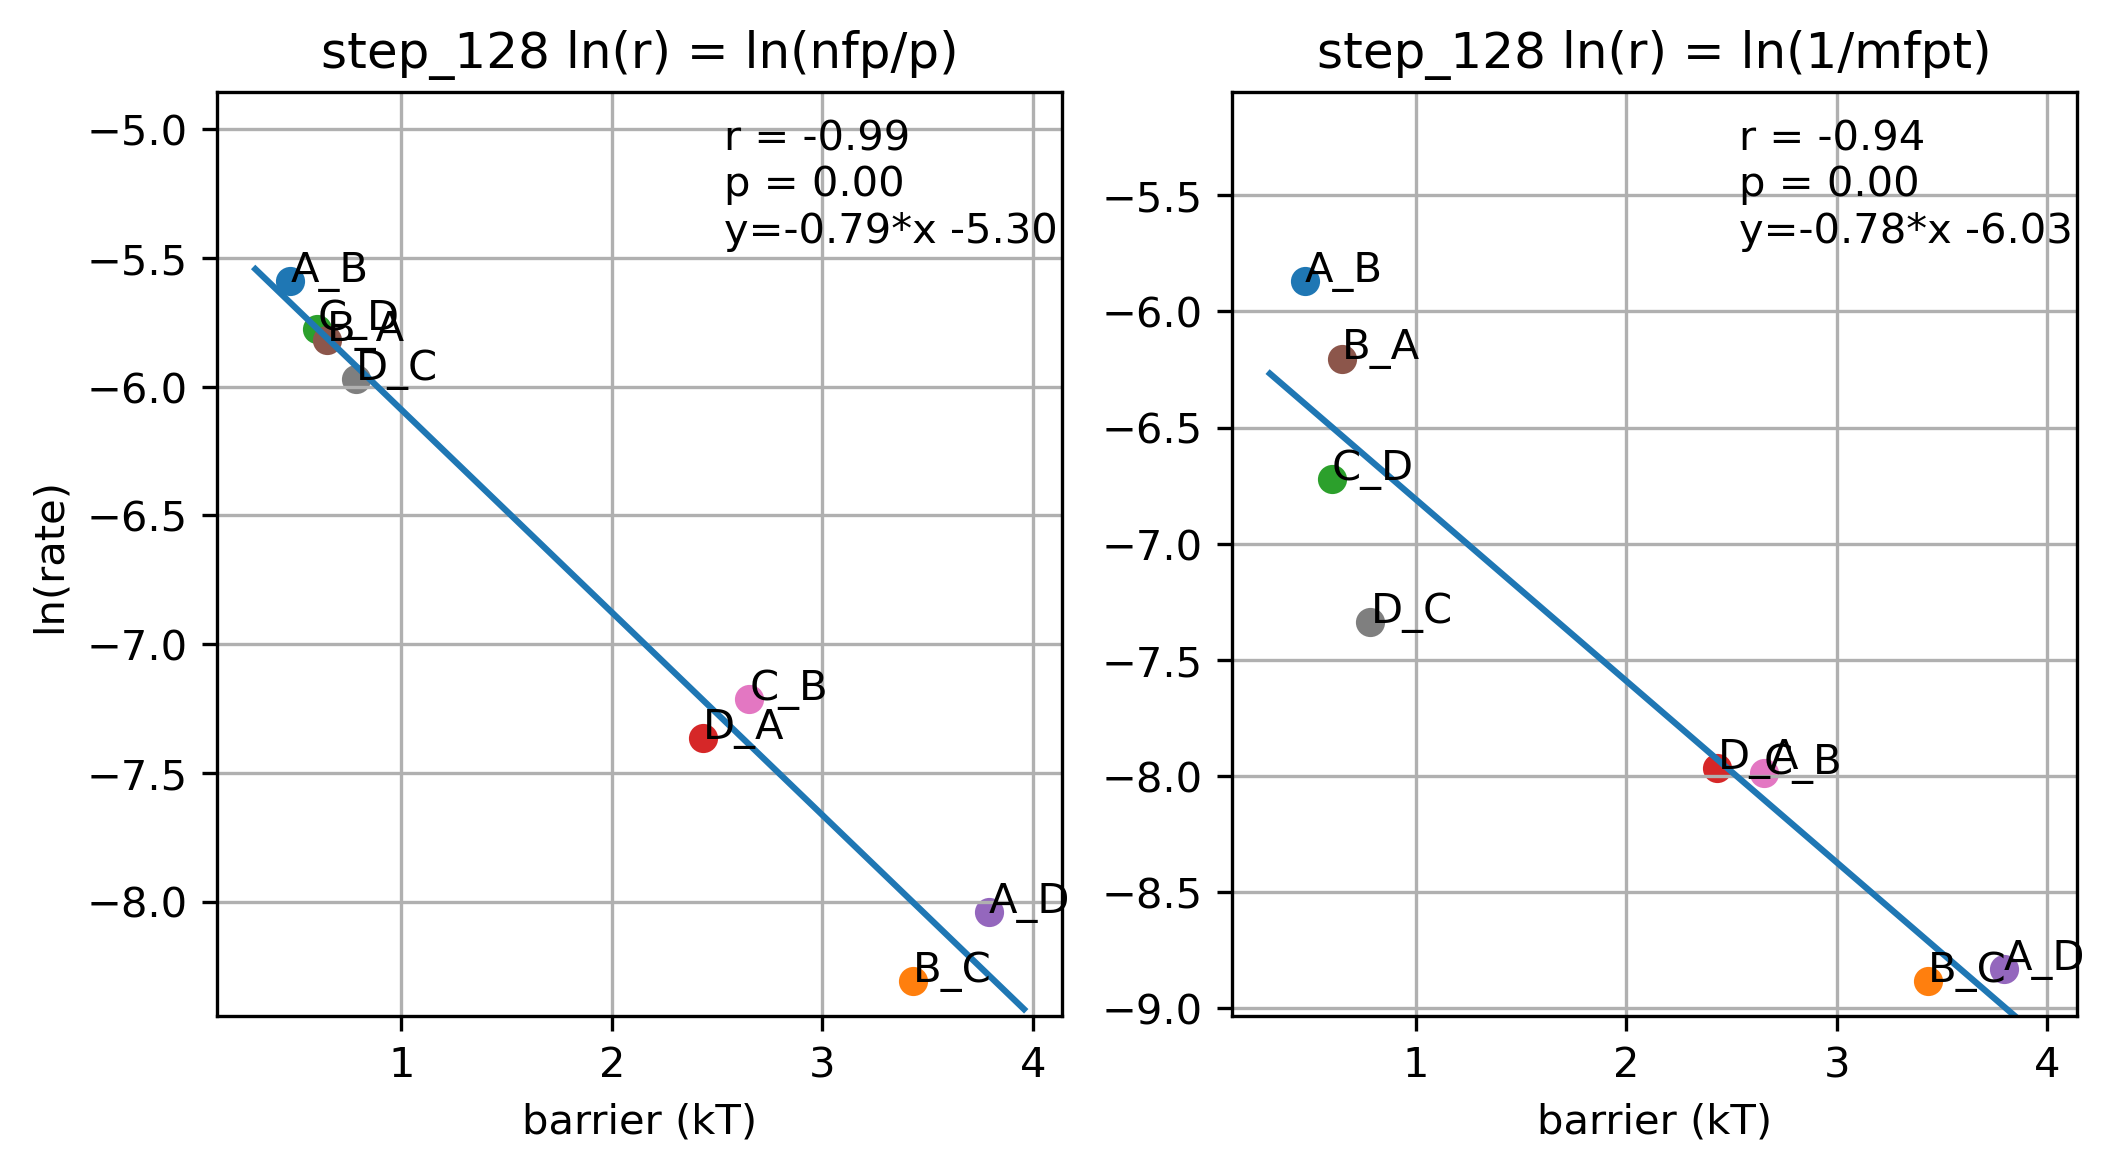

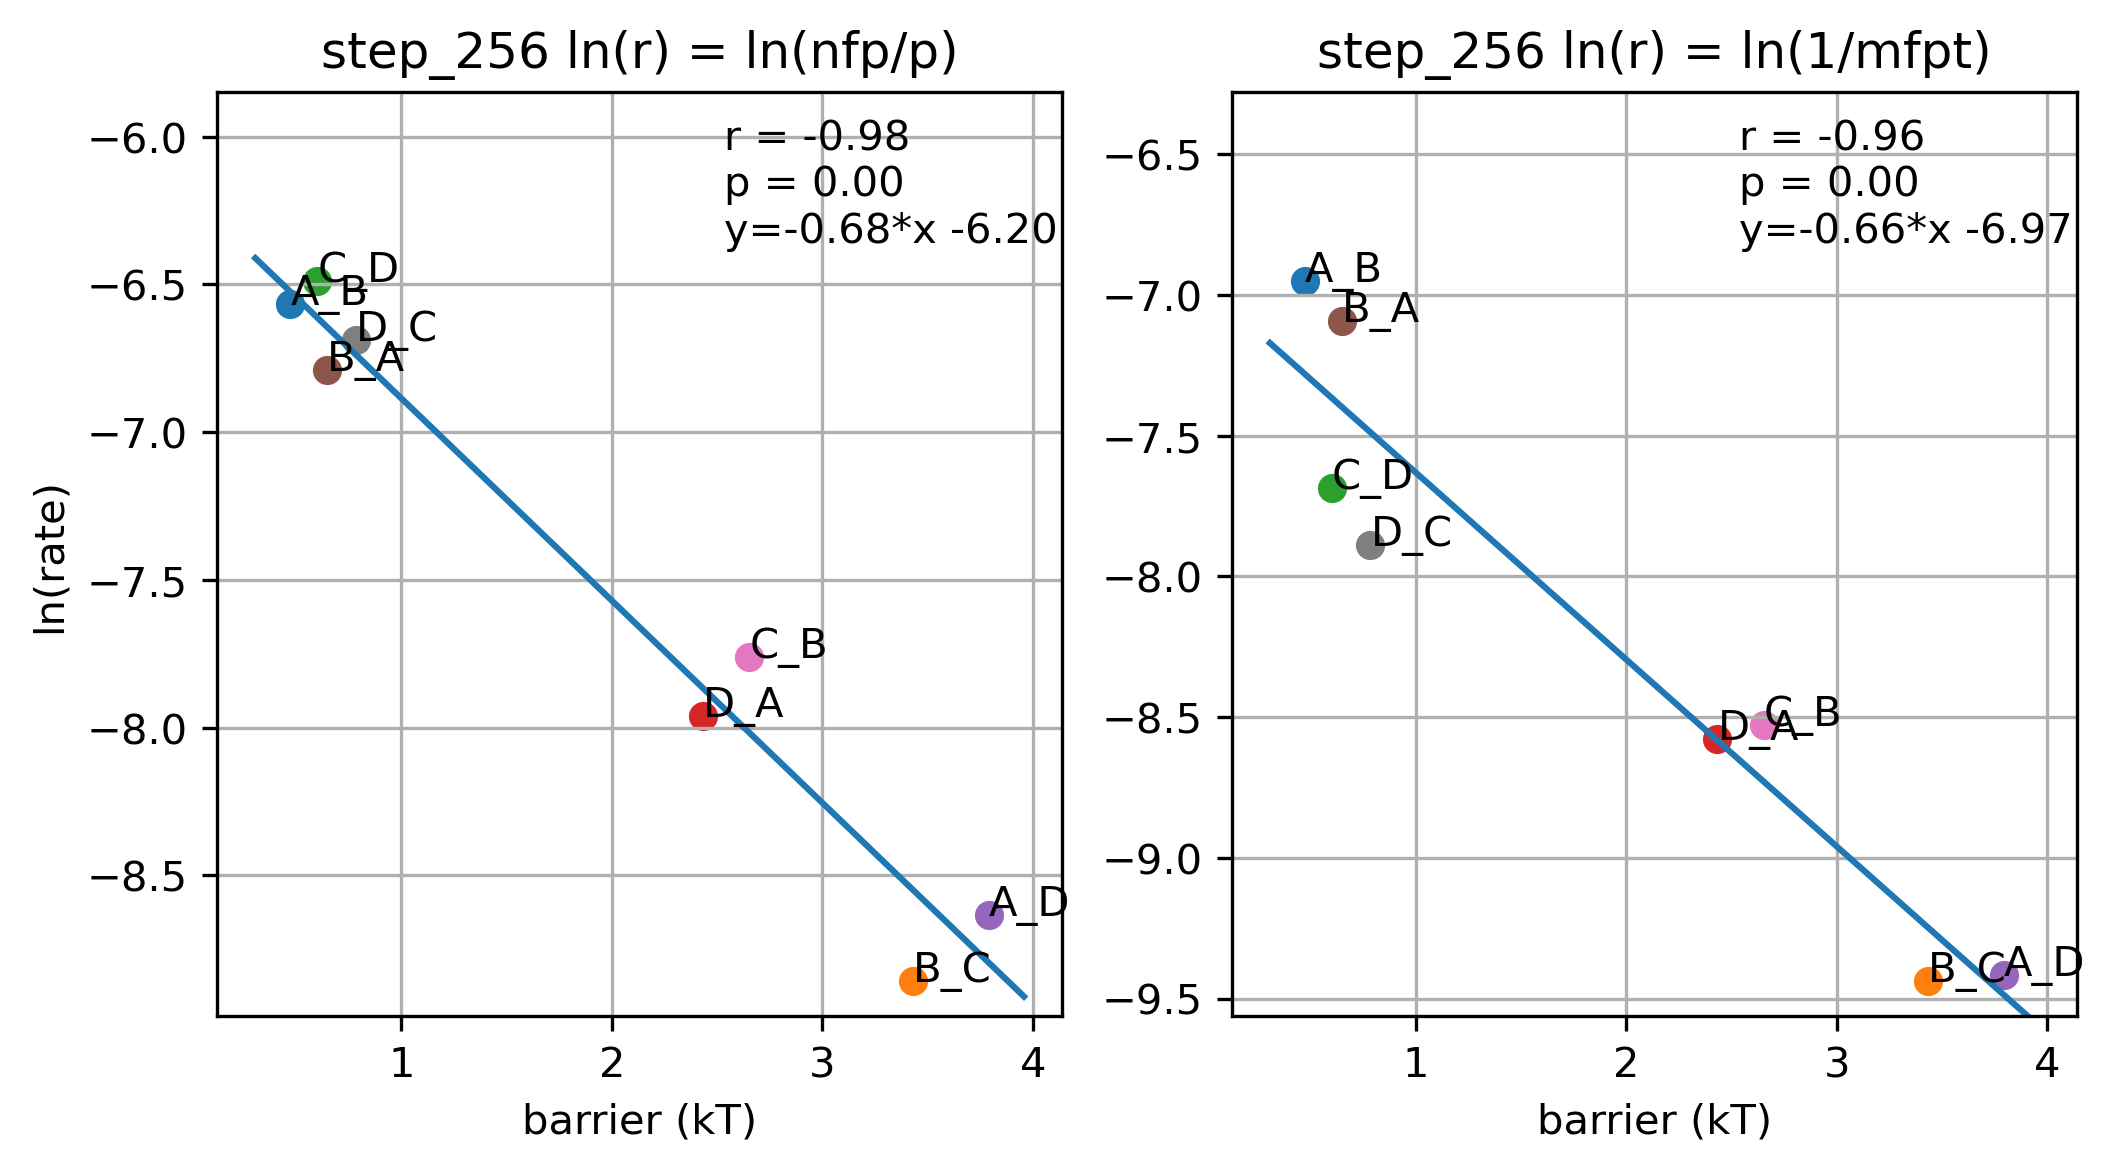

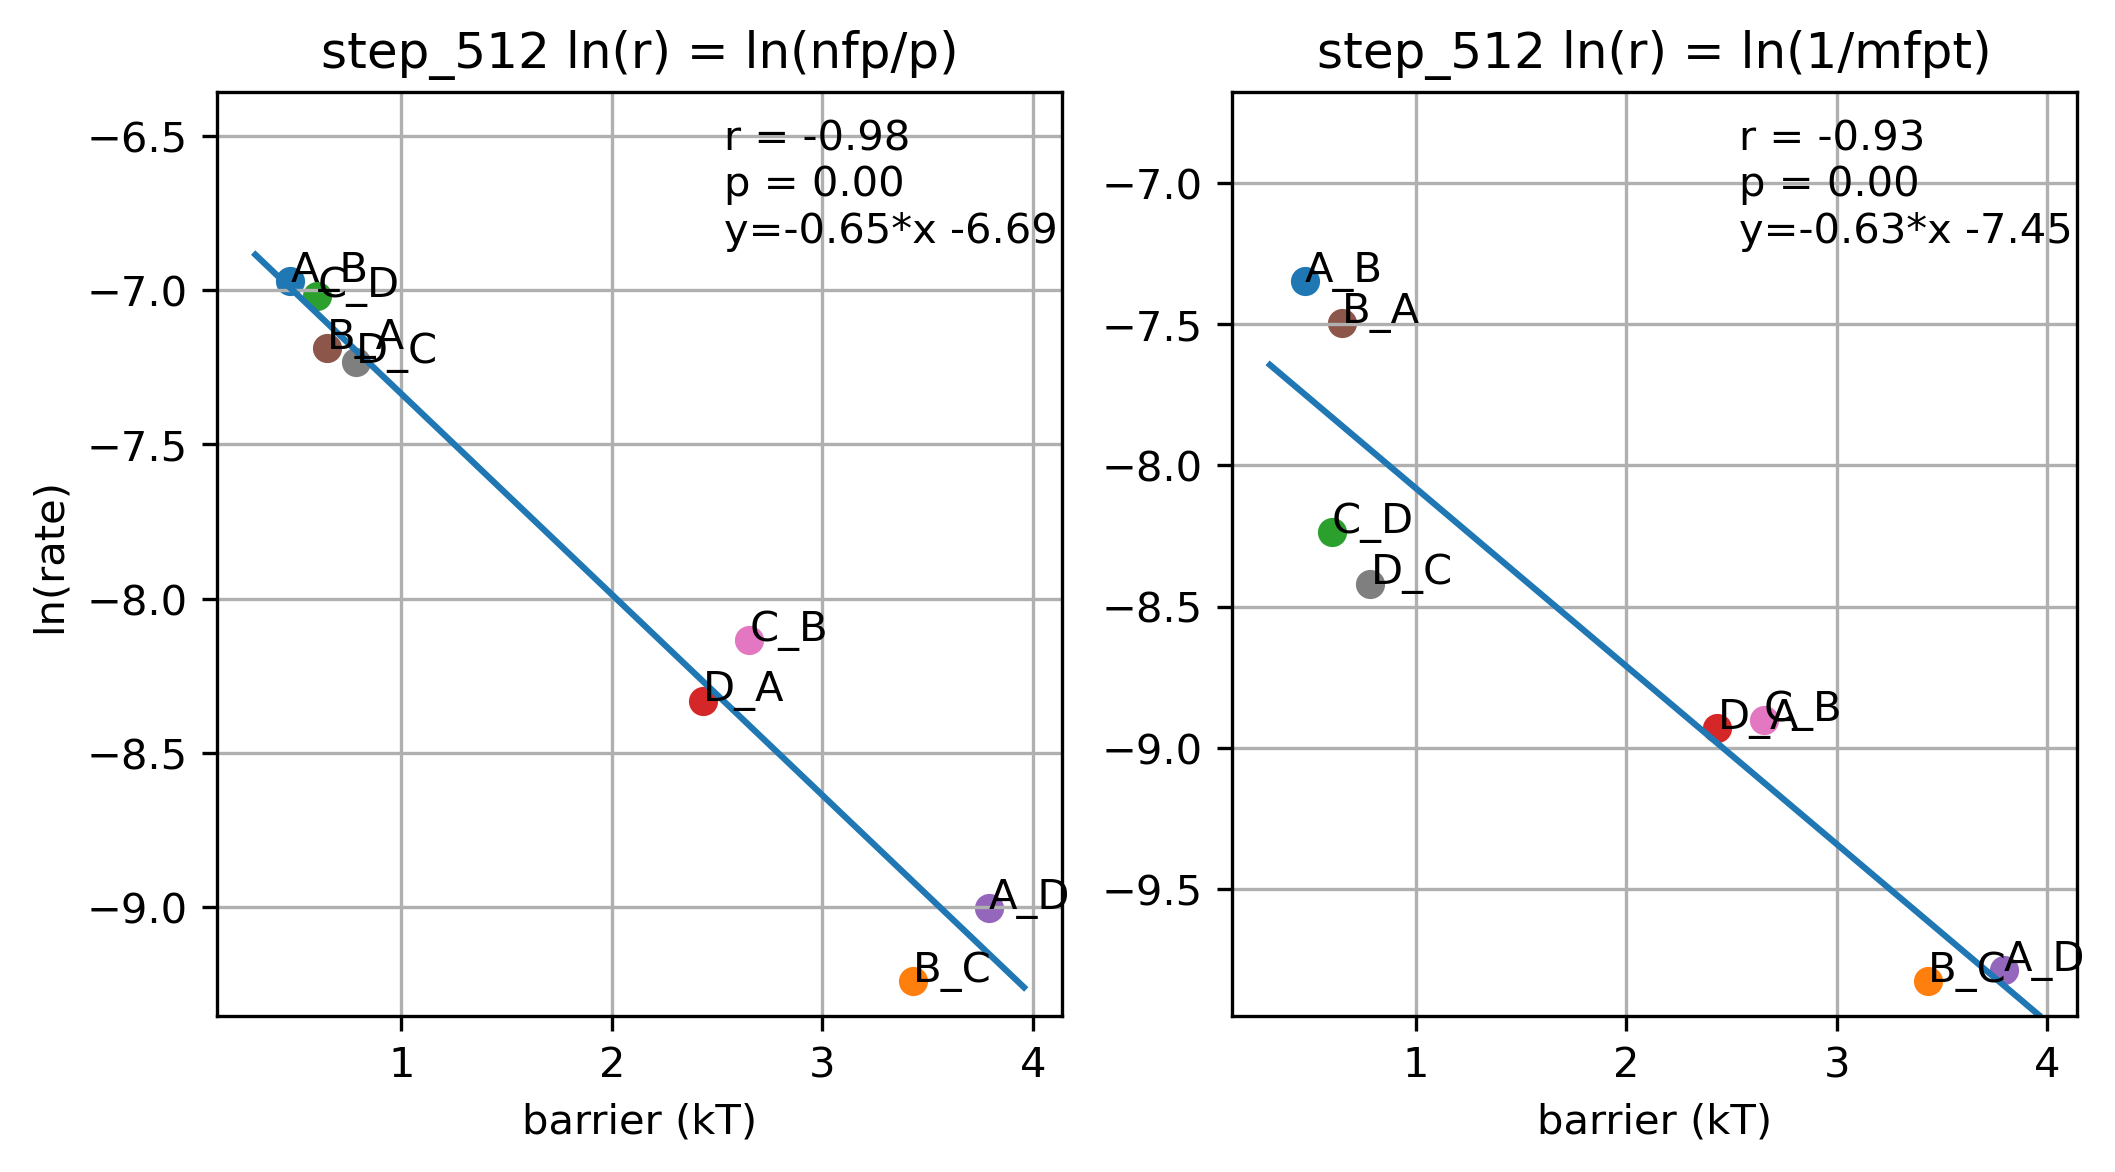

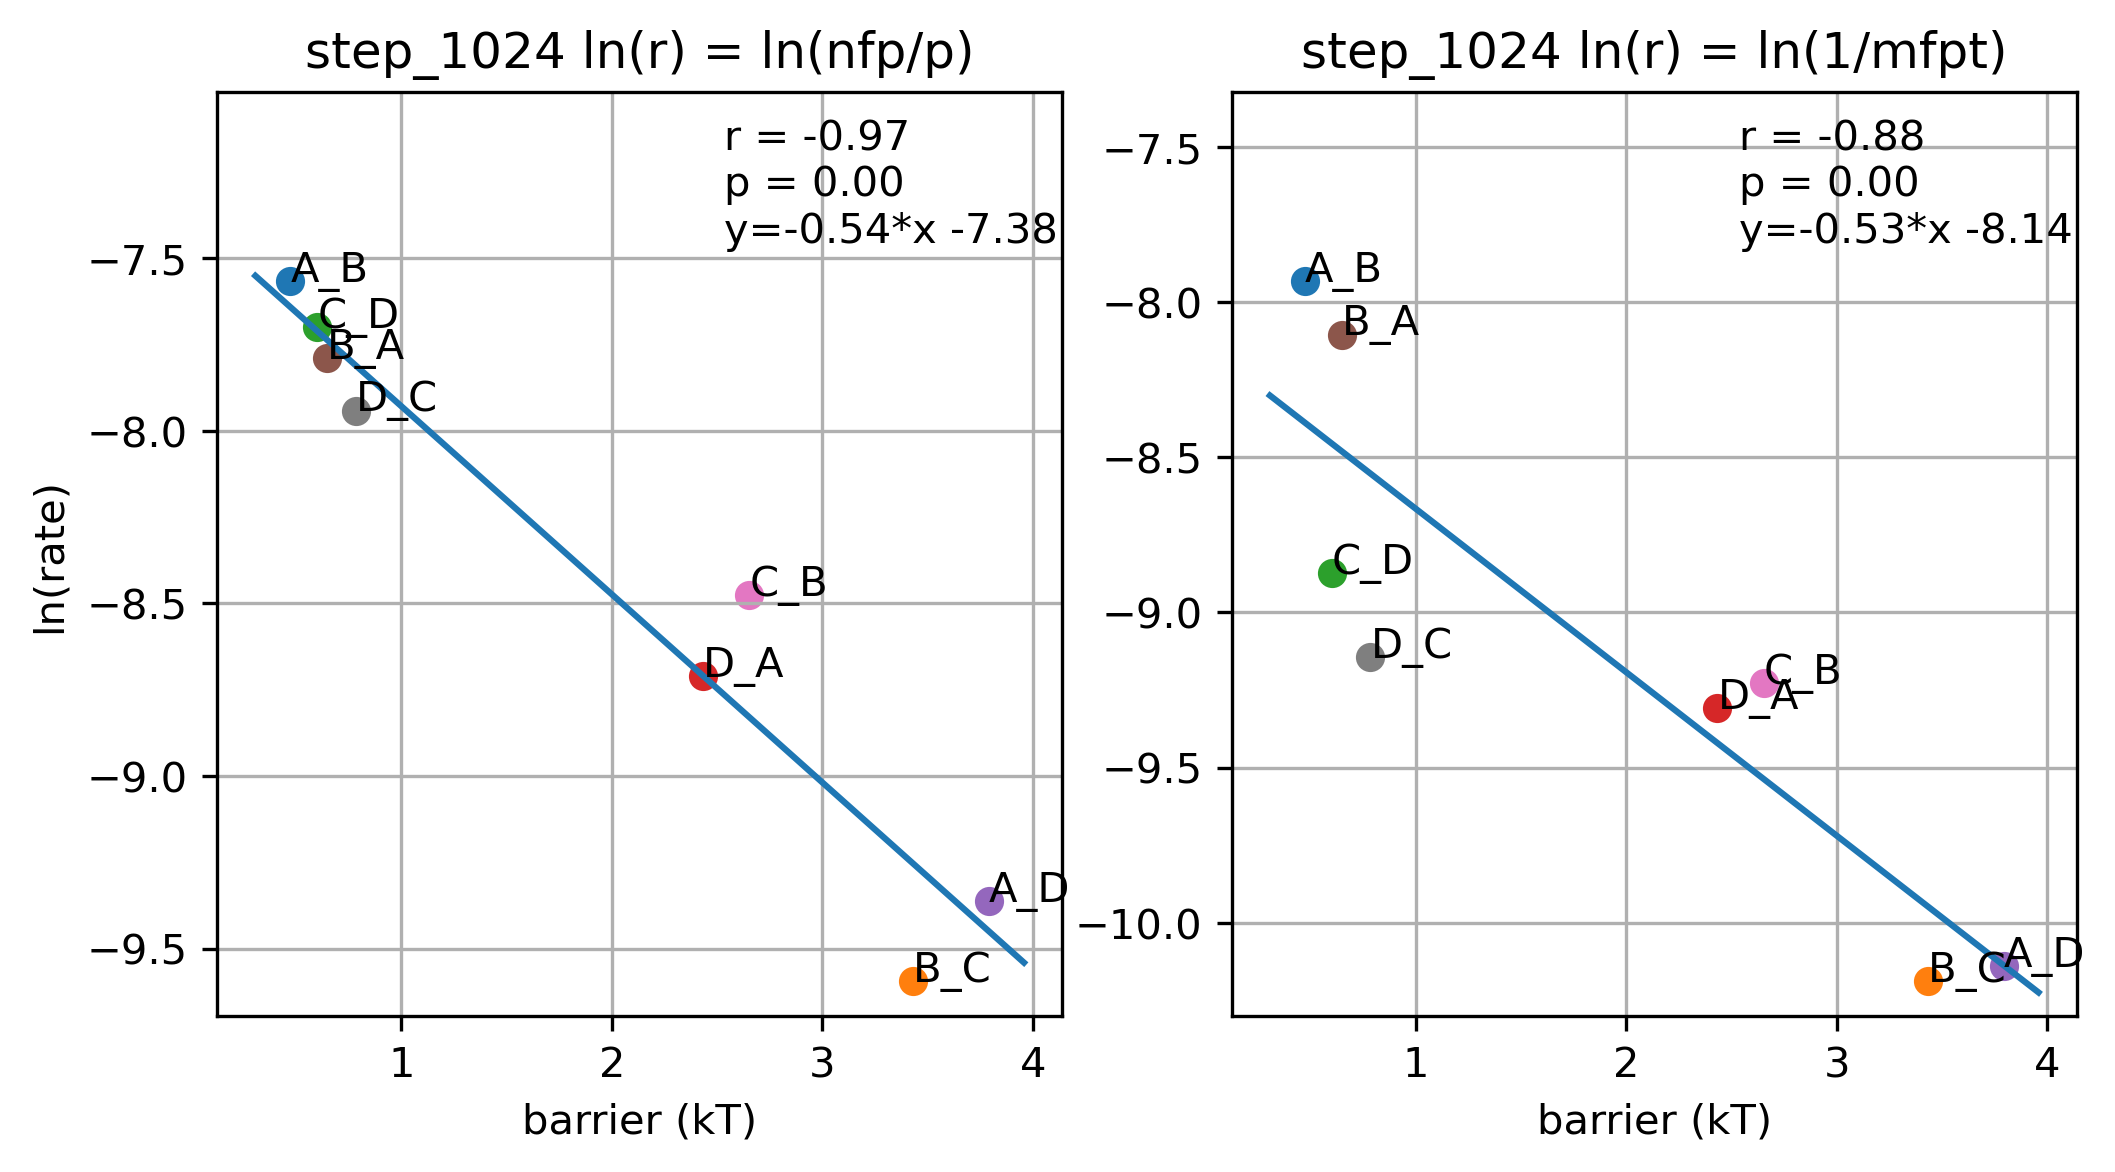

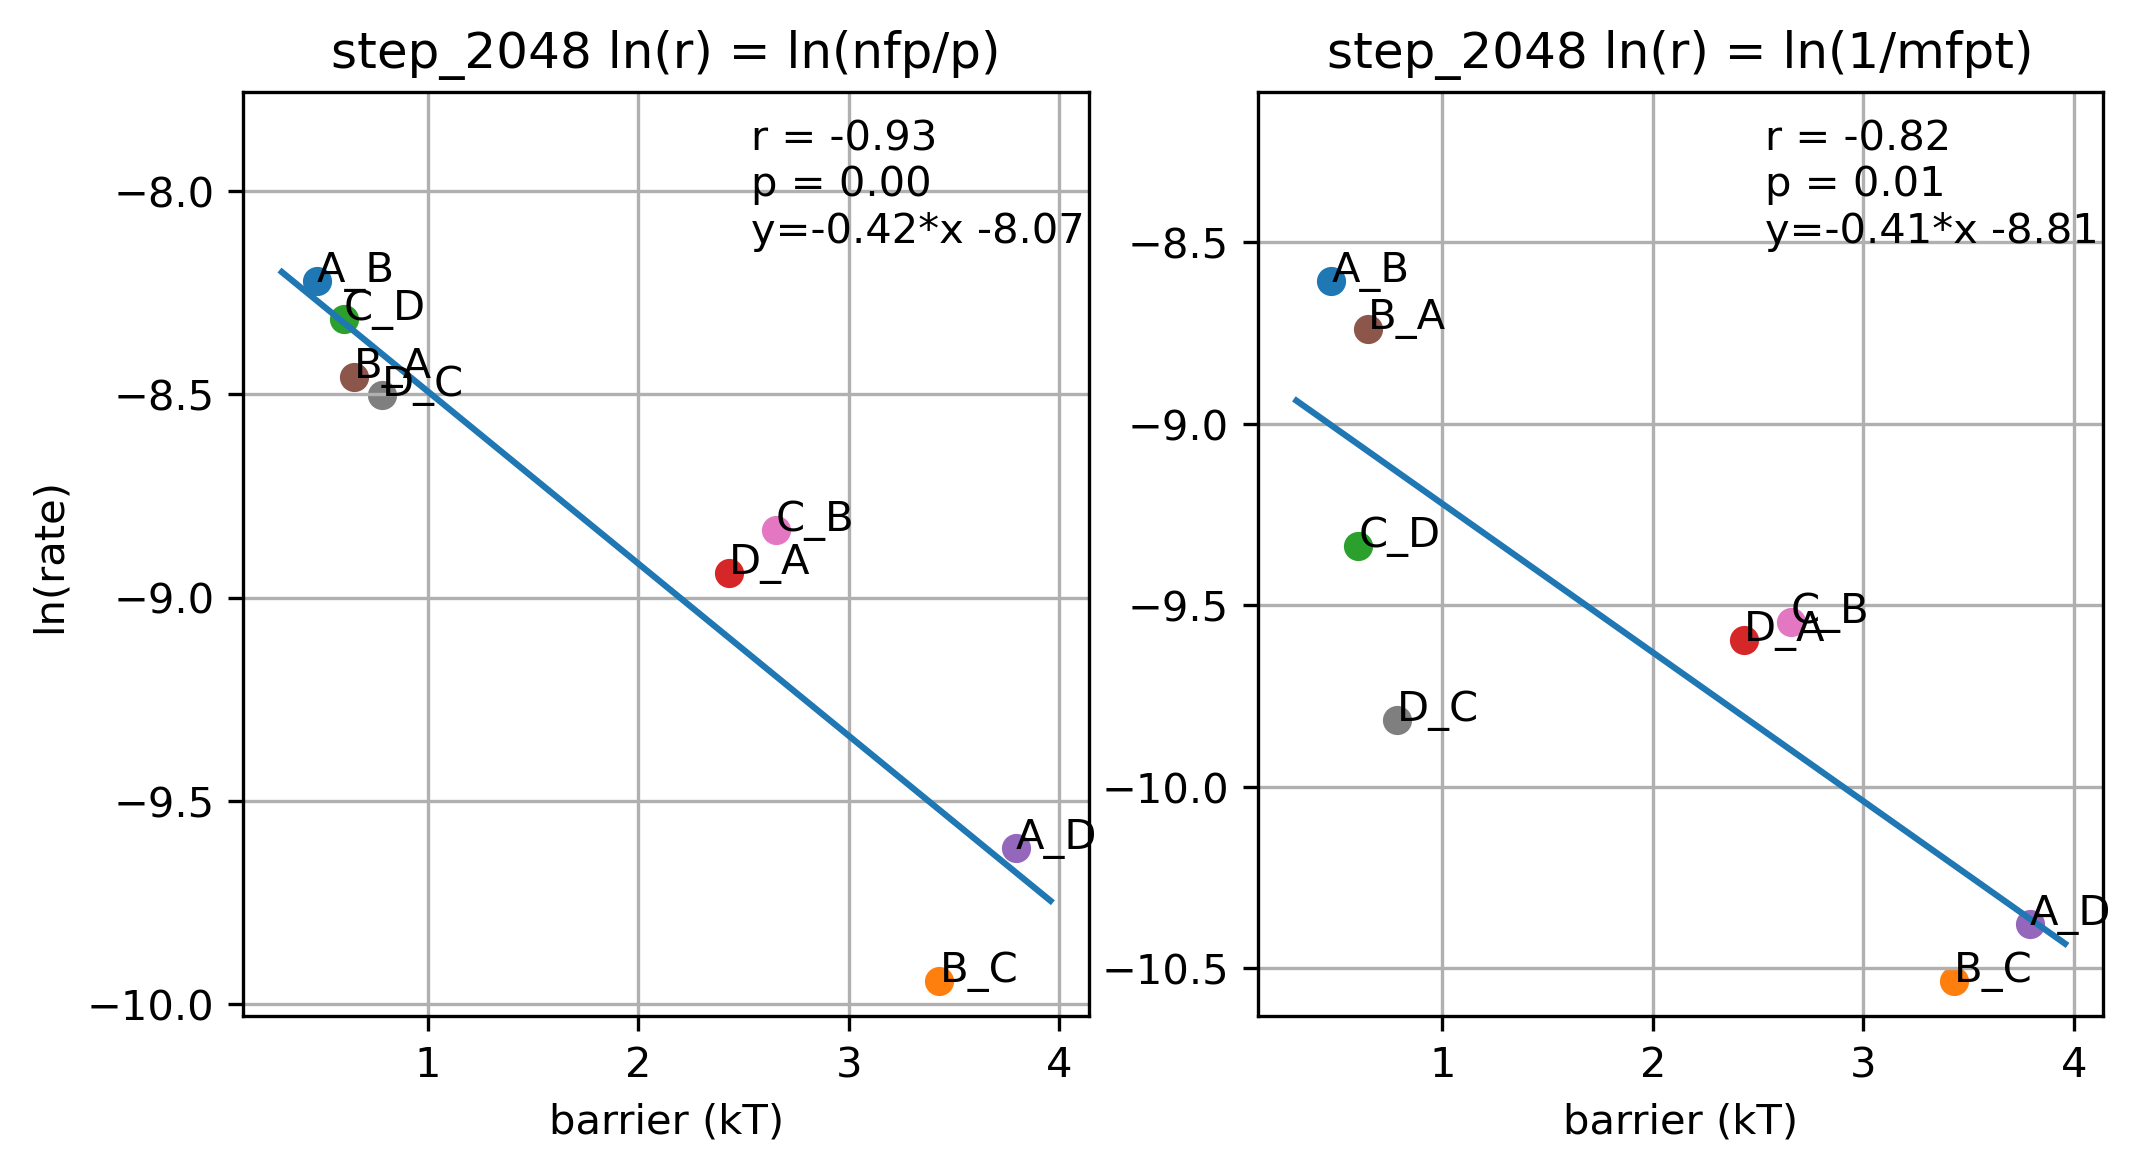

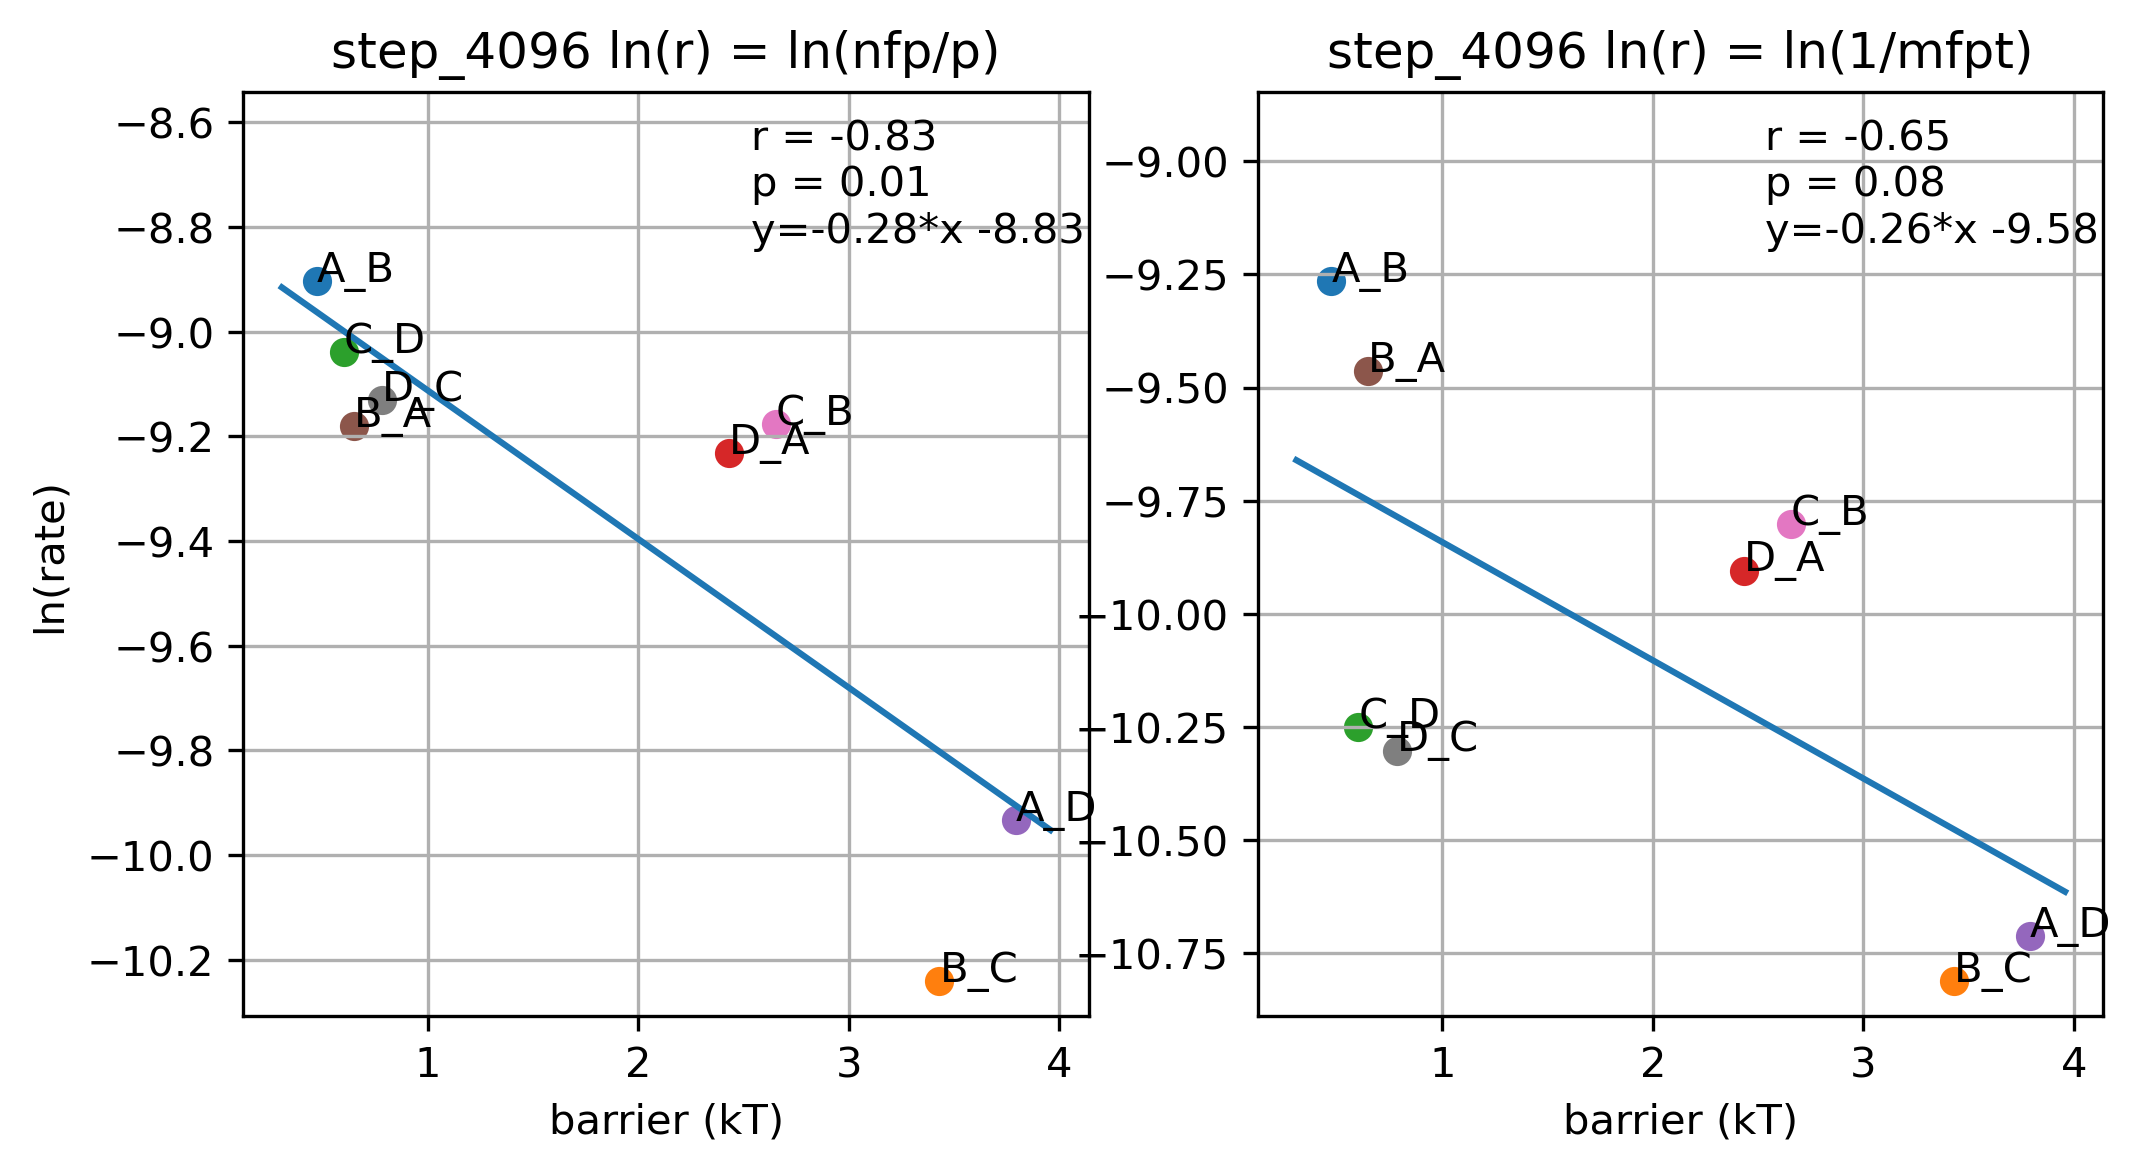

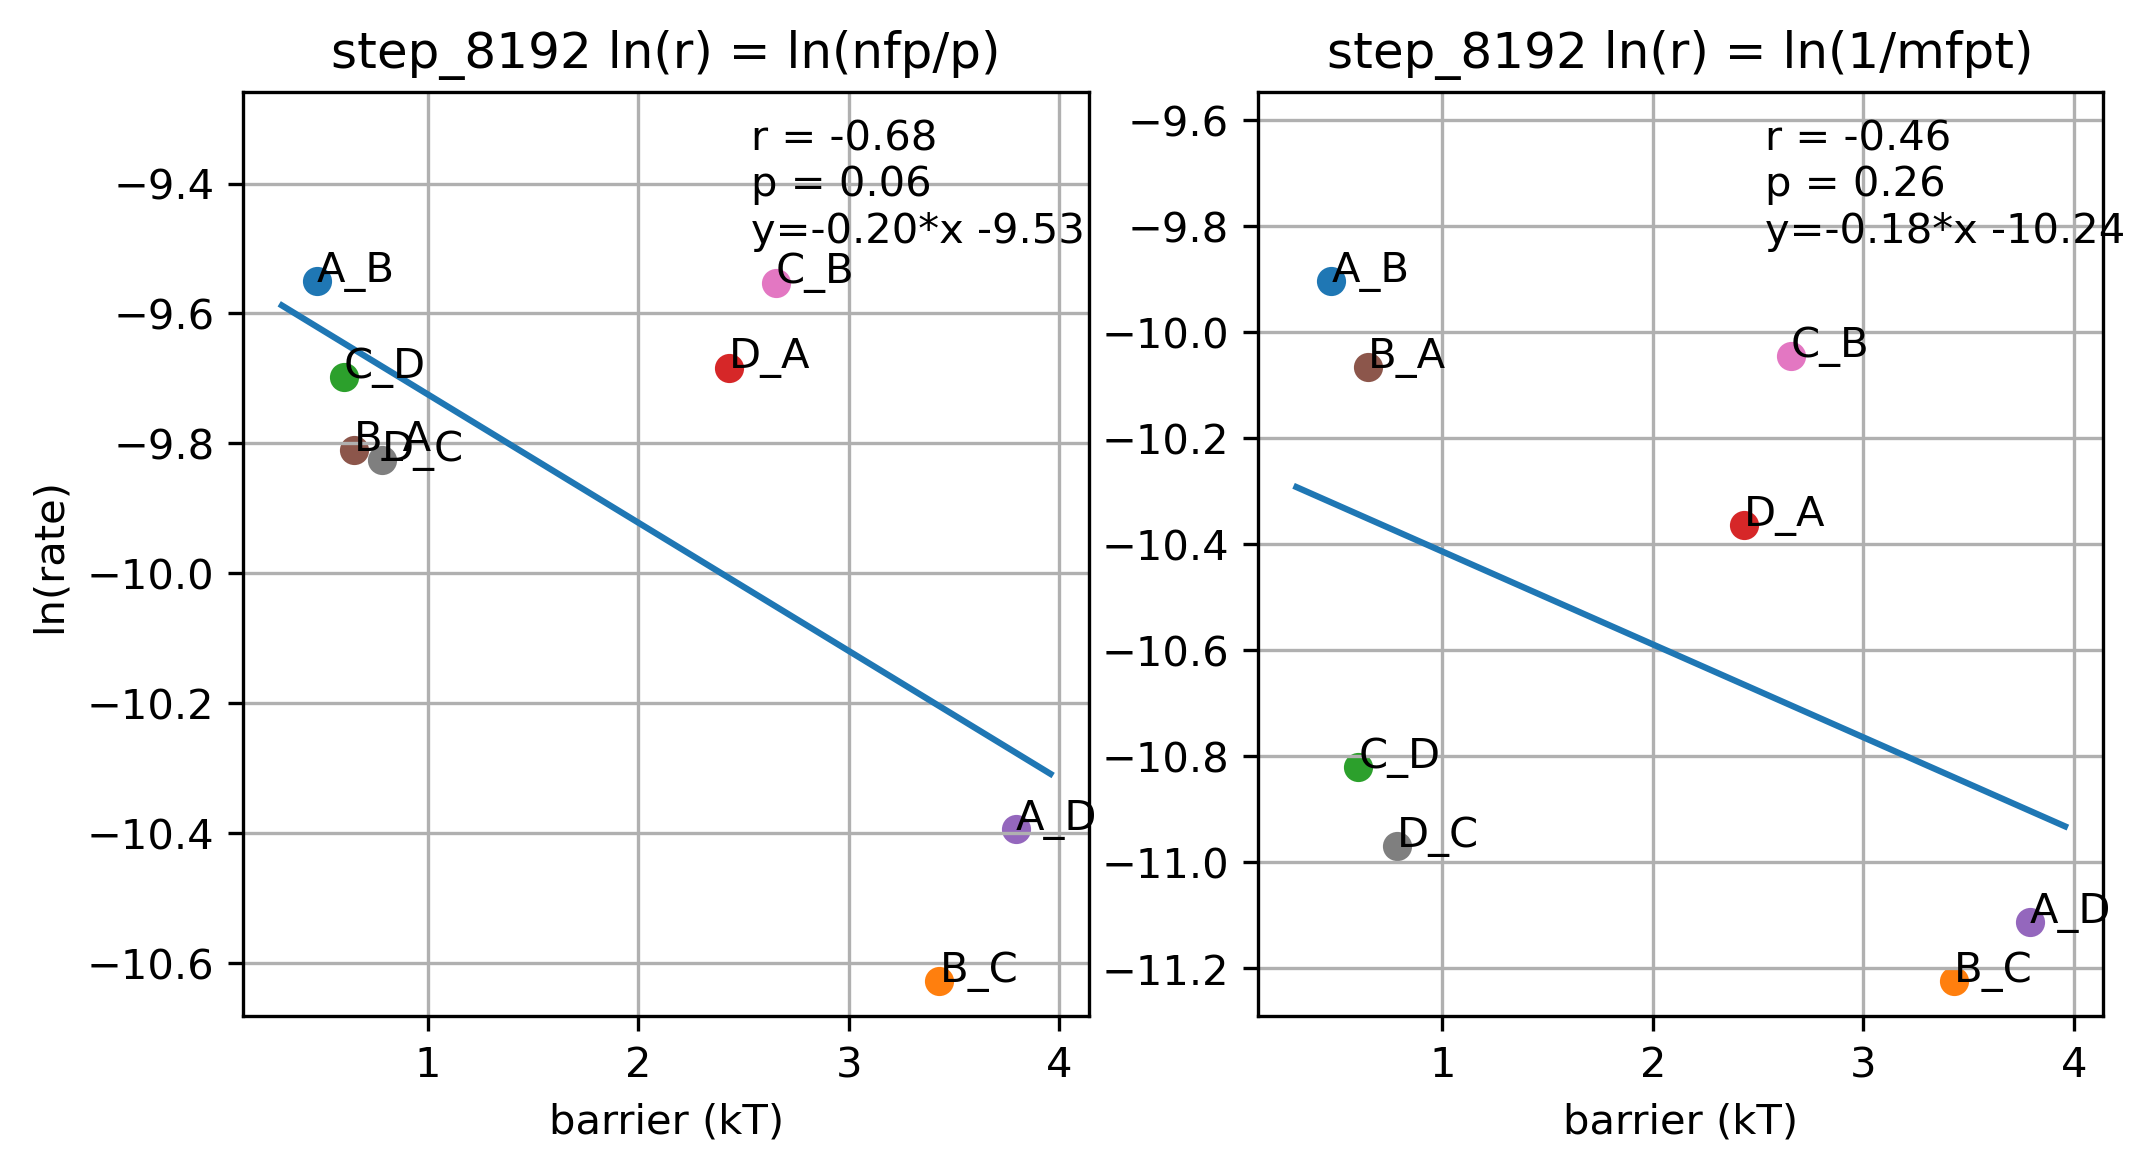

In [64]:
for step_index, step in enumerate(step_list):
    fig, (ax1, ax2) = plt.subplots(1,2,dpi=300, figsize=(8,4))
    x_data, y_data = scatter_all_barrier(ax1, barrier_ref, b_name, step_index, rate_nft)
    increase_ylim(ax1)
    linear_regression(ax1, x_data, y_data)
    ax1.set_title(f"step_{step_list[step_index]} ln(r) = ln(nfp/p)")
    
    x_data, y_data = scatter_all_barrier(ax2, barrier_ref, b_name, step_index, rate_mfpt)
    increase_ylim(ax2)
    linear_regression(ax2, x_data, y_data)
    ax2.set_title(f"step_{step_list[step_index]} ln(r) = ln(1/mfpt)")
    
    ax1.set_ylabel("ln(rate)")
    for ax in [ax1, ax2]:
        ax.grid()
        ax.set_xlabel("barrier (kT)")
        
    plt.savefig(f"rate_{step:04d}.png")


# Does lumping helps?

In [39]:
rate_mfpt = {i:[] for i in ["A_C", "C_A"]}
rate_nft  = {i:[] for i in ["A_C", "C_A"]}

step_list = [1,       2,    4,    8,  16,
             32,     64,  128,  256, 512,
             1024, 2048, 4096, 8192]

for step in step_list:
    print(step)
    msm = Sfilter.MSM.SF_msm([])
    msm.set_state_str([traj[::step] for traj in traj_list])
    msm.time_step = [step]*10
    msm.calc_state_array([["A", "B"],["C", "D"]])
    
    for b_name in ["A_C", "C_A"]:
        i_s,j_s = b_name.split("_")
        
        r = msm.get_mfpt_rate_pair(msm.s_2_int[i_s], msm.s_2_int[j_s])[0]
        rate_mfpt[b_name].append(r)
        
        r = msm.get_nfp_rate_pair(msm.s_2_int[i_s], msm.s_2_int[j_s])[0]
        rate_nft[b_name].append(r)

1
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192


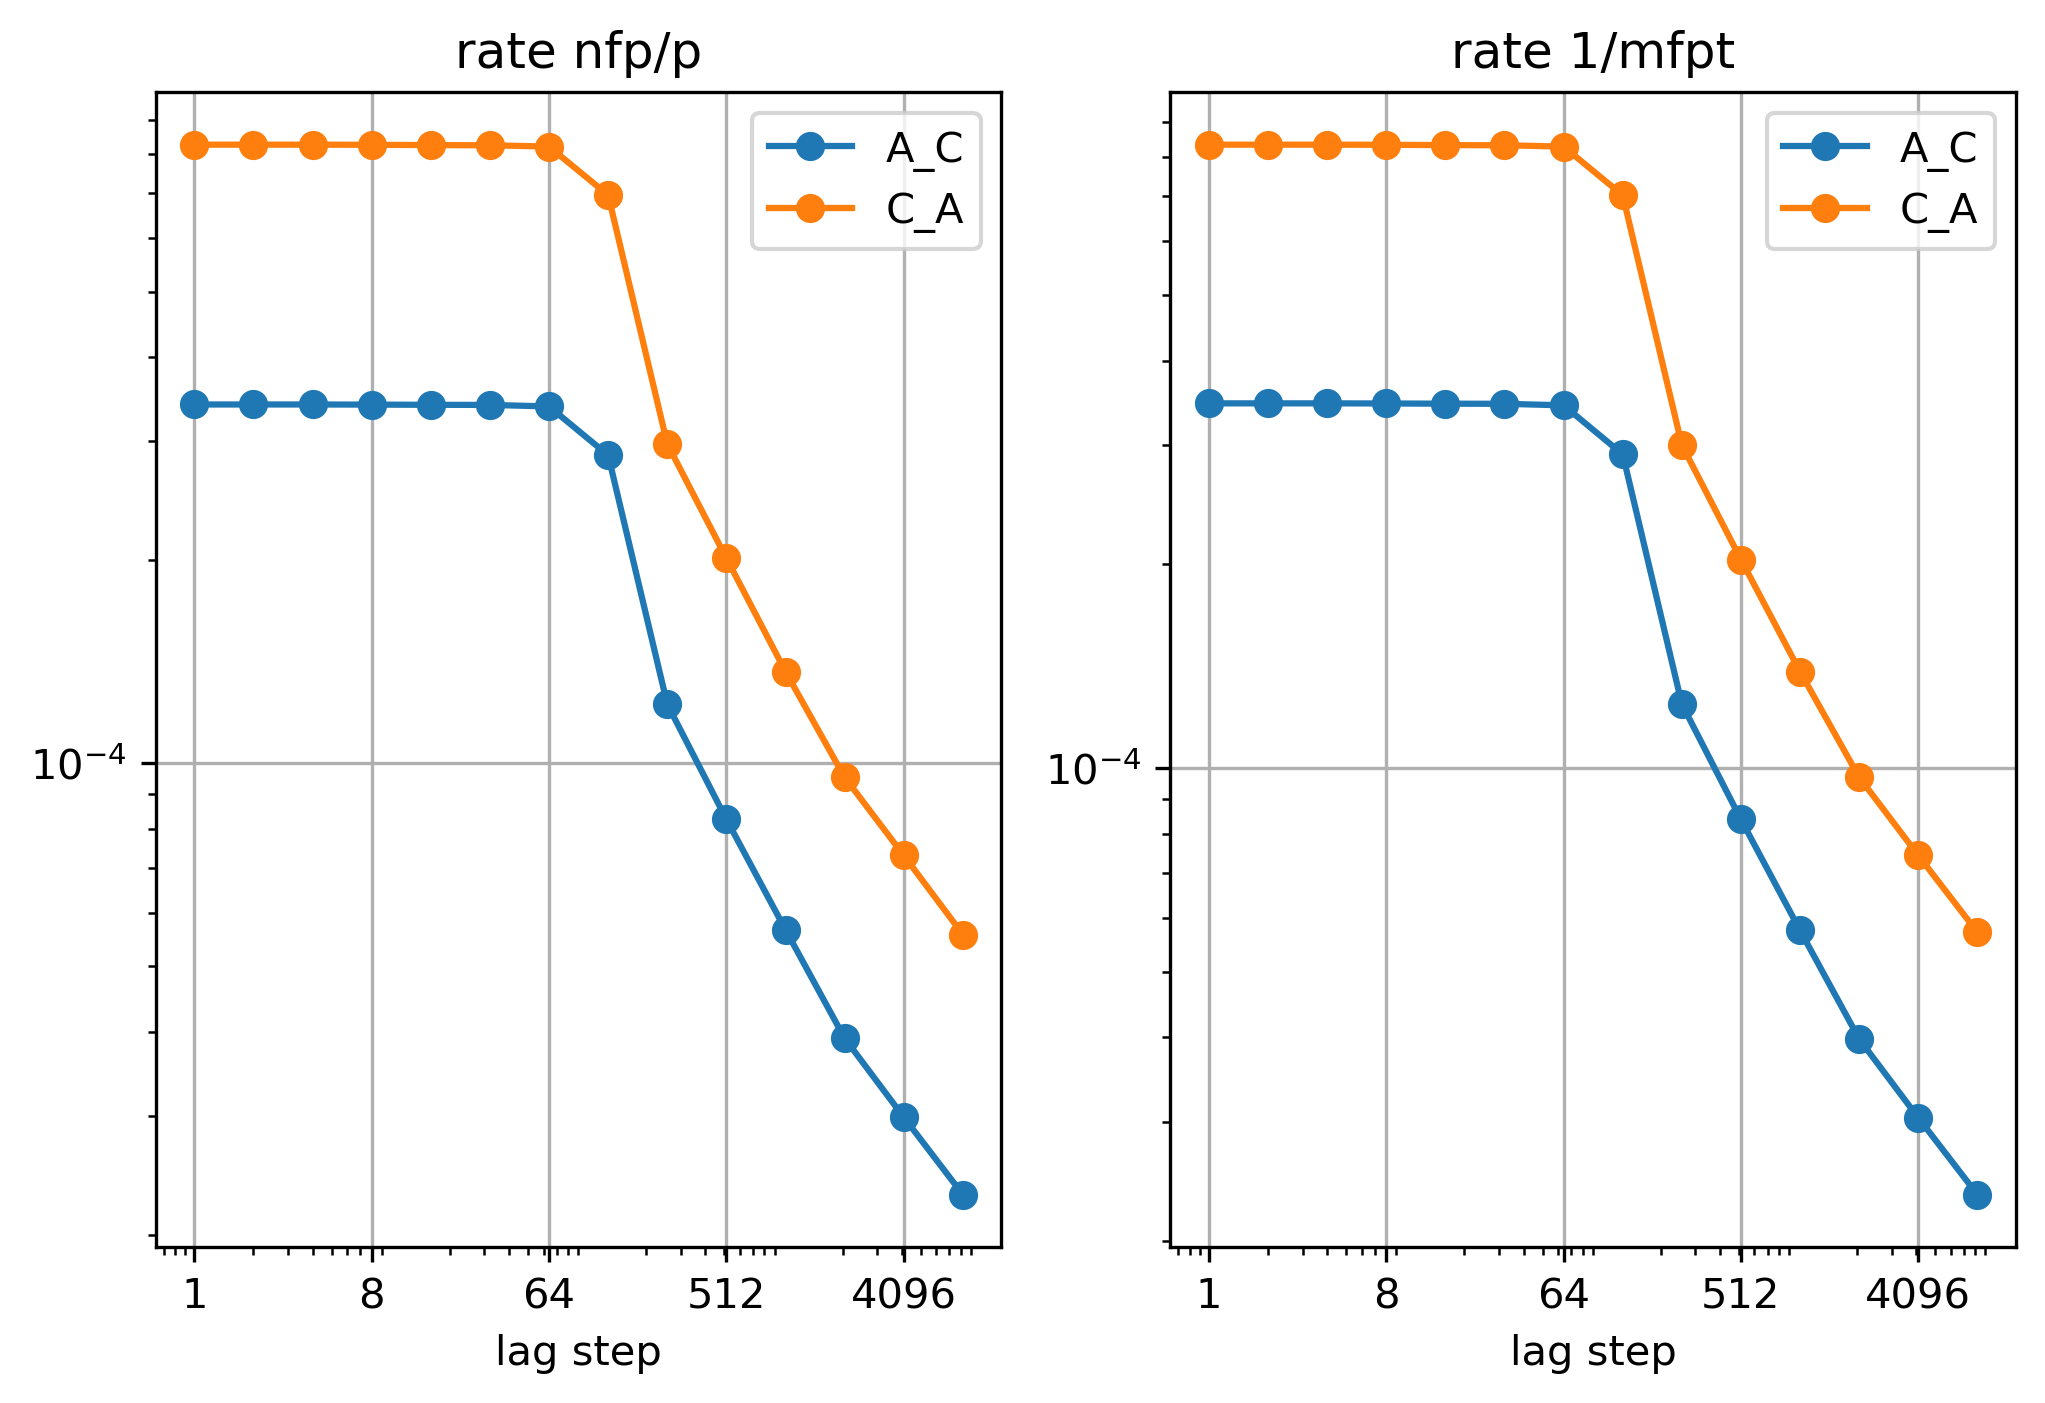

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2,dpi=300, figsize=(8,5))

ax = ax1
for reaction in ["A_C", "C_A"]:
    ax.plot(step_list, rate_nft[reaction], "o-", label=reaction)
    
ax = ax2
for reaction in ["A_C", "C_A"]:
    ax.plot(step_list, rate_mfpt[reaction], "o-", label=reaction)

ax1.set_title("rate nfp/p")
ax2.set_title("rate 1/mfpt")

for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlabel("lag step")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks(step_list[::3], step_list[::3])
    ax.legend()

